In [2]:
## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nepal-2015-earthquake-dataset/test_values.csv
/kaggle/input/nepal-2015-earthquake-dataset/train_labels.csv
/kaggle/input/nepal-2015-earthquake-dataset/submission_format.csv
/kaggle/input/nepal-2015-earthquake-dataset/train_values.csv


# Import Dependencies

In [3]:
import numpy as np
import json
import os
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.stats import uniform, randint
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# Load the Files

In [4]:
df_train = pd.read_csv("/kaggle/input/nepal-2015-earthquake-dataset/train_values.csv")
df_test = pd.read_csv("/kaggle/input/nepal-2015-earthquake-dataset/test_values.csv")
df_train_labels = pd.read_csv("/kaggle/input/nepal-2015-earthquake-dataset/train_labels.csv")
submission_format = pd.read_csv("/kaggle/input/nepal-2015-earthquake-dataset/submission_format.csv")

# Exploratory Data Analysis

In [5]:
df_train = df_train.drop(["building_id"],axis=1)
df_test = df_test.drop(["building_id"],axis=1)

In [6]:
df_train.head(n=10)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
1,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,0
2,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
3,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
4,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,0
5,8,558,6089,2,10,9,5,t,r,n,...,1,0,0,0,0,0,0,0,0,0
6,9,475,12066,2,25,3,4,n,r,n,...,0,0,0,0,0,0,0,0,0,0
7,20,323,12236,2,0,8,6,t,w,q,...,0,0,0,0,0,0,0,0,0,0
8,0,757,7219,2,15,8,6,t,r,q,...,0,0,0,0,0,0,0,0,0,0
9,26,886,994,1,0,13,4,t,i,n,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df_train_labels.head(10)

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3
5,333020,2
6,728451,3
7,475515,1
8,441126,2
9,989500,1


In [8]:
df_test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,17,596,11307,3,20,7,6,t,r,n,...,0,0,0,0,0,0,0,0,0,0
1,6,141,11987,2,25,13,5,t,r,n,...,1,0,0,0,0,0,0,0,0,0
2,22,19,10044,2,5,4,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
3,26,39,633,1,0,19,3,t,r,x,...,0,0,1,0,0,0,0,0,0,0
4,17,289,7970,3,15,8,7,t,r,q,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df_train.describe()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
count,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,...,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,0.034332,...,0.064378,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119
std,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,0.182081,...,0.245426,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-null 

In [11]:
## lets separate columns on the basis of datatypes: numeric(continous), numeric(binary), object(String)

cols_geo = ["geo_level_1_id", "geo_level_2_id", "geo_level_3_id"] #3
cols_num = ["count_floors_pre_eq","age", "area_percentage", "height_percentage", "count_families"] #5


In [12]:
 g = df_train.columns.to_series().groupby(df_train.dtypes).groups
#{dtype('int64'): ['A', 'E'], dtype('float64'): ['B'], dtype('O'): ['C', 'D']}
g_dict = {k.name: v for k, v in g.items()}

In [13]:
cols_obj = [i for i in g_dict['object']]
cols_obj

['land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'legal_ownership_status']

In [14]:
cols_int = [i for i in g_dict['int64'] if i != "building_id"]
cols_int

['geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',
 'count_floors_pre_eq',
 'age',
 'area_percentage',
 'height_percentage',
 'has_superstructure_adobe_mud',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_stone_flag',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_timber',
 'has_superstructure_bamboo',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other',
 'count_families',
 'has_secondary_use',
 'has_secondary_use_agriculture',
 'has_secondary_use_hotel',
 'has_secondary_use_rental',
 'has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_secondary_use_use_police',
 'has_secondary_use_other']

In [15]:
cols_bin = [i for i in cols_int if (i not in cols_num and i not in cols_geo)]
cols_bin

['has_superstructure_adobe_mud',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_stone_flag',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_timber',
 'has_superstructure_bamboo',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other',
 'has_secondary_use',
 'has_secondary_use_agriculture',
 'has_secondary_use_hotel',
 'has_secondary_use_rental',
 'has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_secondary_use_use_police',
 'has_secondary_use_other']

In [16]:
total_cols = len(cols_bin)+  len(cols_num) + len(cols_obj) + len(cols_geo)
#total_cols
print("Binary columns count   :", len(cols_bin))
print("Numeric columns count  :", len(cols_num))
print("String columns count   :", len(cols_obj))
print("Geo_level columns count:", len(cols_geo))
print("Total columns count    :", total_cols)

Binary columns count   : 22
Numeric columns count  : 5
String columns count   : 8
Geo_level columns count: 3
Total columns count    : 38


### EDA of Labels

In [17]:
## Set default seaborn plot parameterssns.set(style="whitegrid")
default_annotation_params = {
    'ha': 'center',
    'va': 'center',
    'fontsize': 10,
    'color': 'black',
    'xytext': (0, 5),
    'textcoords': 'offset points'
}
sns.set(style="whitegrid")

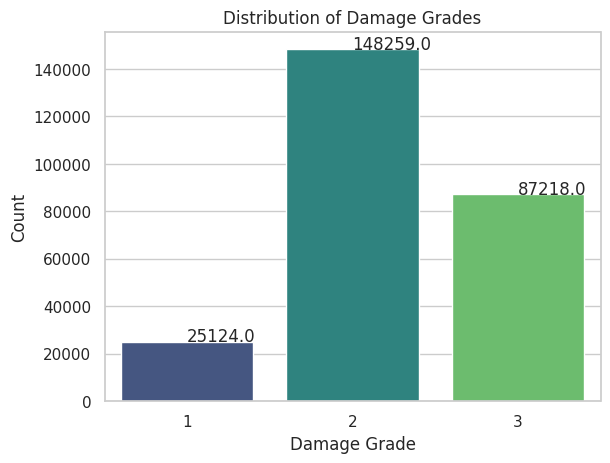

In [18]:
ax = sns.countplot(data=df_train_labels, x='damage_grade', palette='viridis')
#annotations
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()))
    
plt.title('Distribution of Damage Grades')
plt.xlabel('Damage Grade')
plt.ylabel('Count')
plt.show()

Takeways:
- Looks unbalanced against grade_1. 
- Maybe SMOTE later?

### EDA on numerical columns(non-binary)

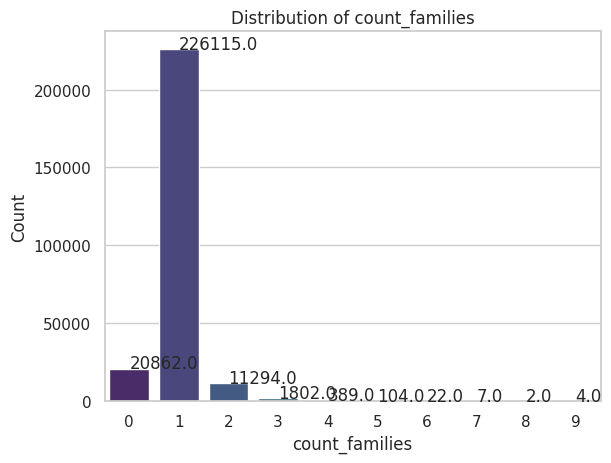

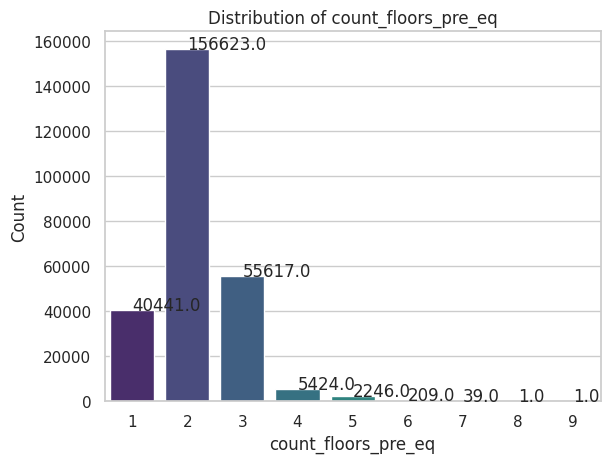

In [19]:
cols_count = ["count_families", "count_floors_pre_eq"]
for c in cols_count:
    ax = sns.countplot(data=df_train, x=c, palette='viridis')
    #annotations
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()))
    
    plt.title(f'Distribution of {c}')
    plt.xlabel(f'{c}')
    plt.ylabel('Count')
    plt.show()


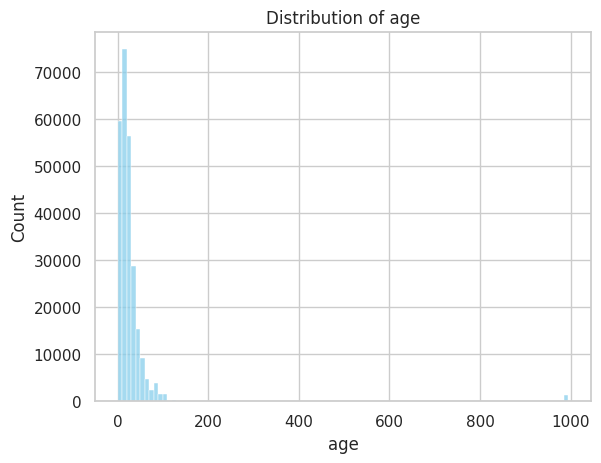

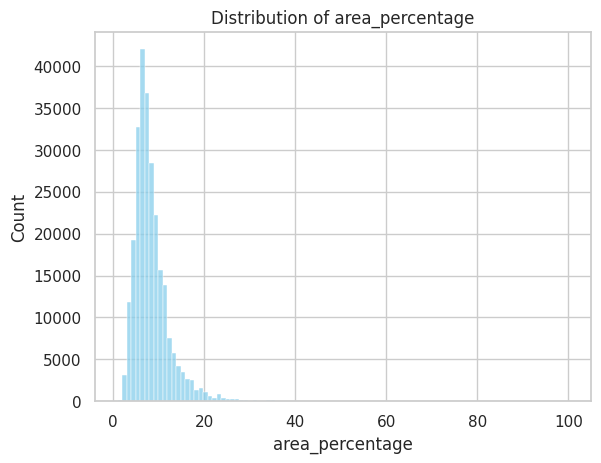

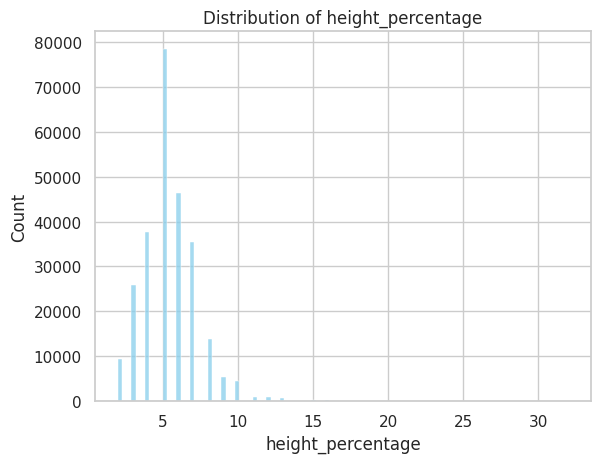

In [20]:
for x in cols_num:
    if x not in cols_count:
        sns.histplot(data=df_train, x=x, bins=100, color='skyblue')
    
    # Show the plot
        plt.title(f'Distribution of {x}')
        plt.show()

Takeways:
- Age looks right skewed
- All rest looks normal enough

### EDA of String Columns

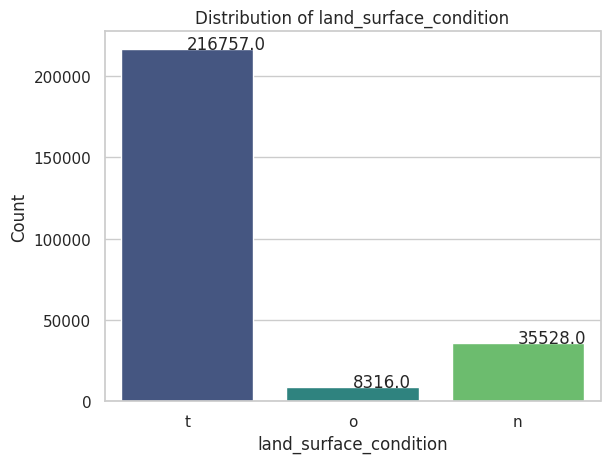

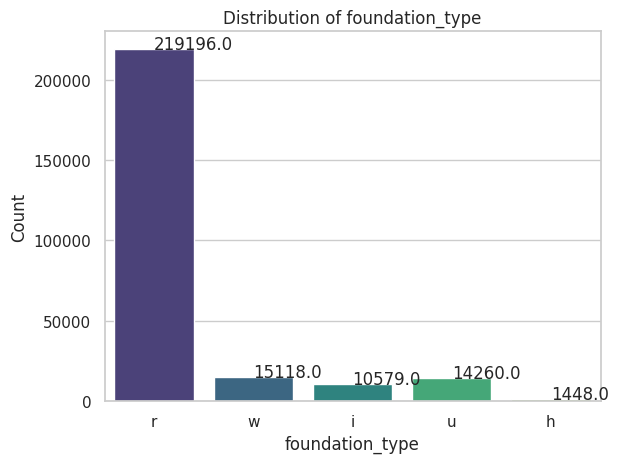

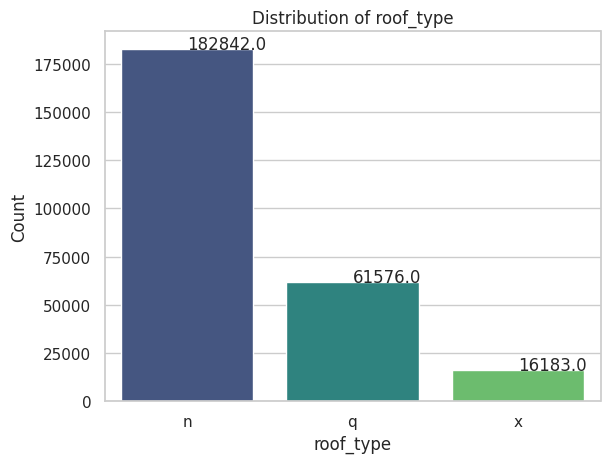

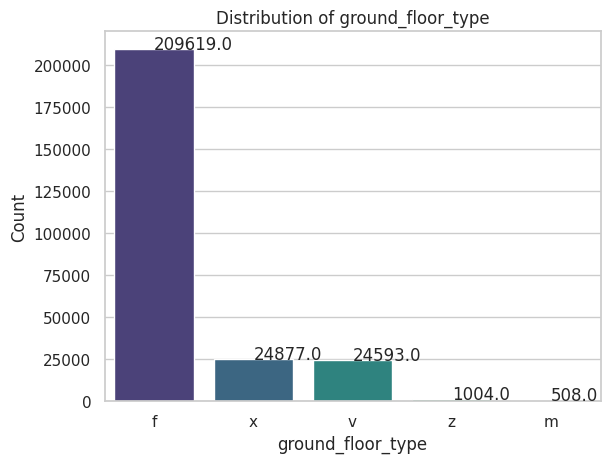

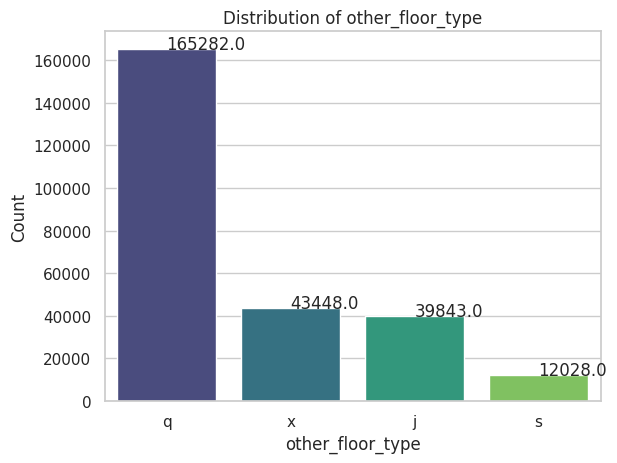

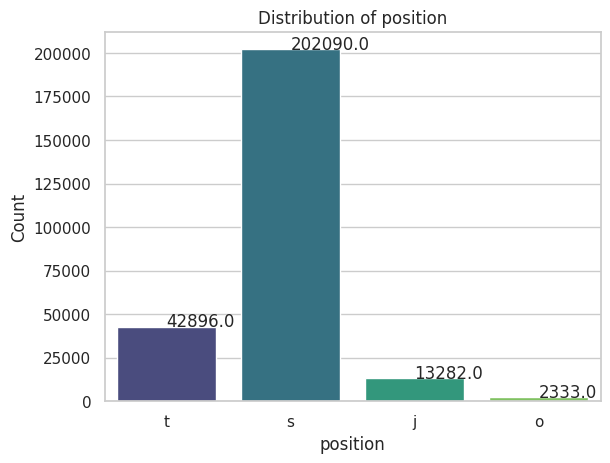

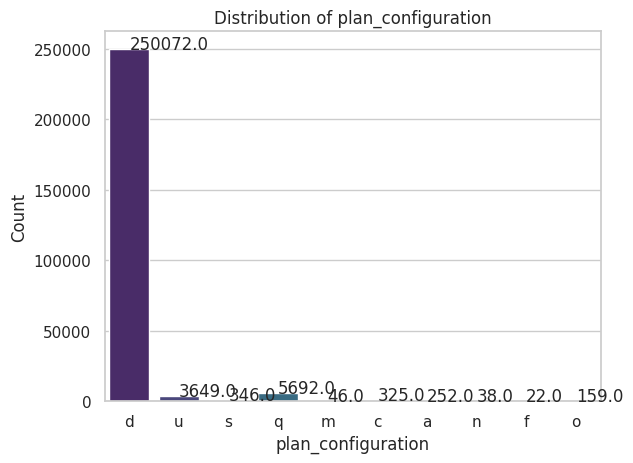

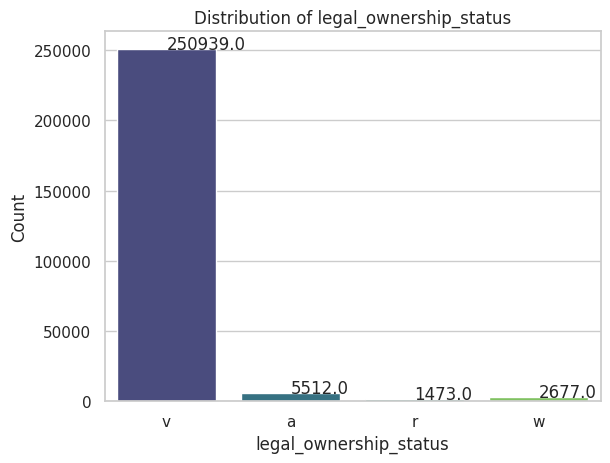

In [21]:
for s in cols_obj:
    ax = sns.countplot(data=df_train, x=s, palette='viridis')
        #annotations
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()))


    plt.title(f'Distribution of {s}')
    plt.xlabel(f'{s}')
    plt.ylabel('Count')
    plt.show()

### Check for duplicates.

In [22]:
duplicated_data = df_train[df_train.duplicated(keep=False)]
print("Number of duplicate entries:", duplicated_data.shape[0])

Number of duplicate entries: 28544


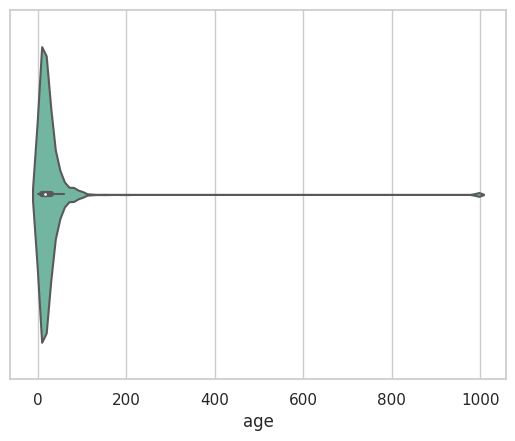

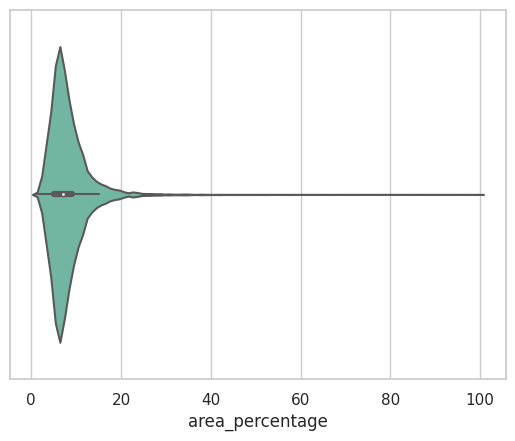

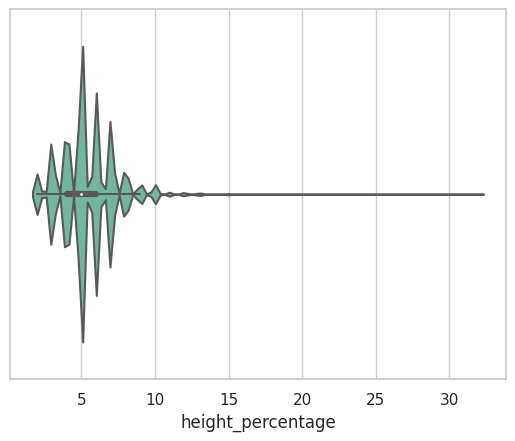

In [23]:
#violin plots
for n in cols_num:
    if n not in cols_count:
        
        sns.violinplot(data=df_train,x=n ,palette='Set2')
        plt.xlabel(f'{n}')
        plt.show()

<Axes: >

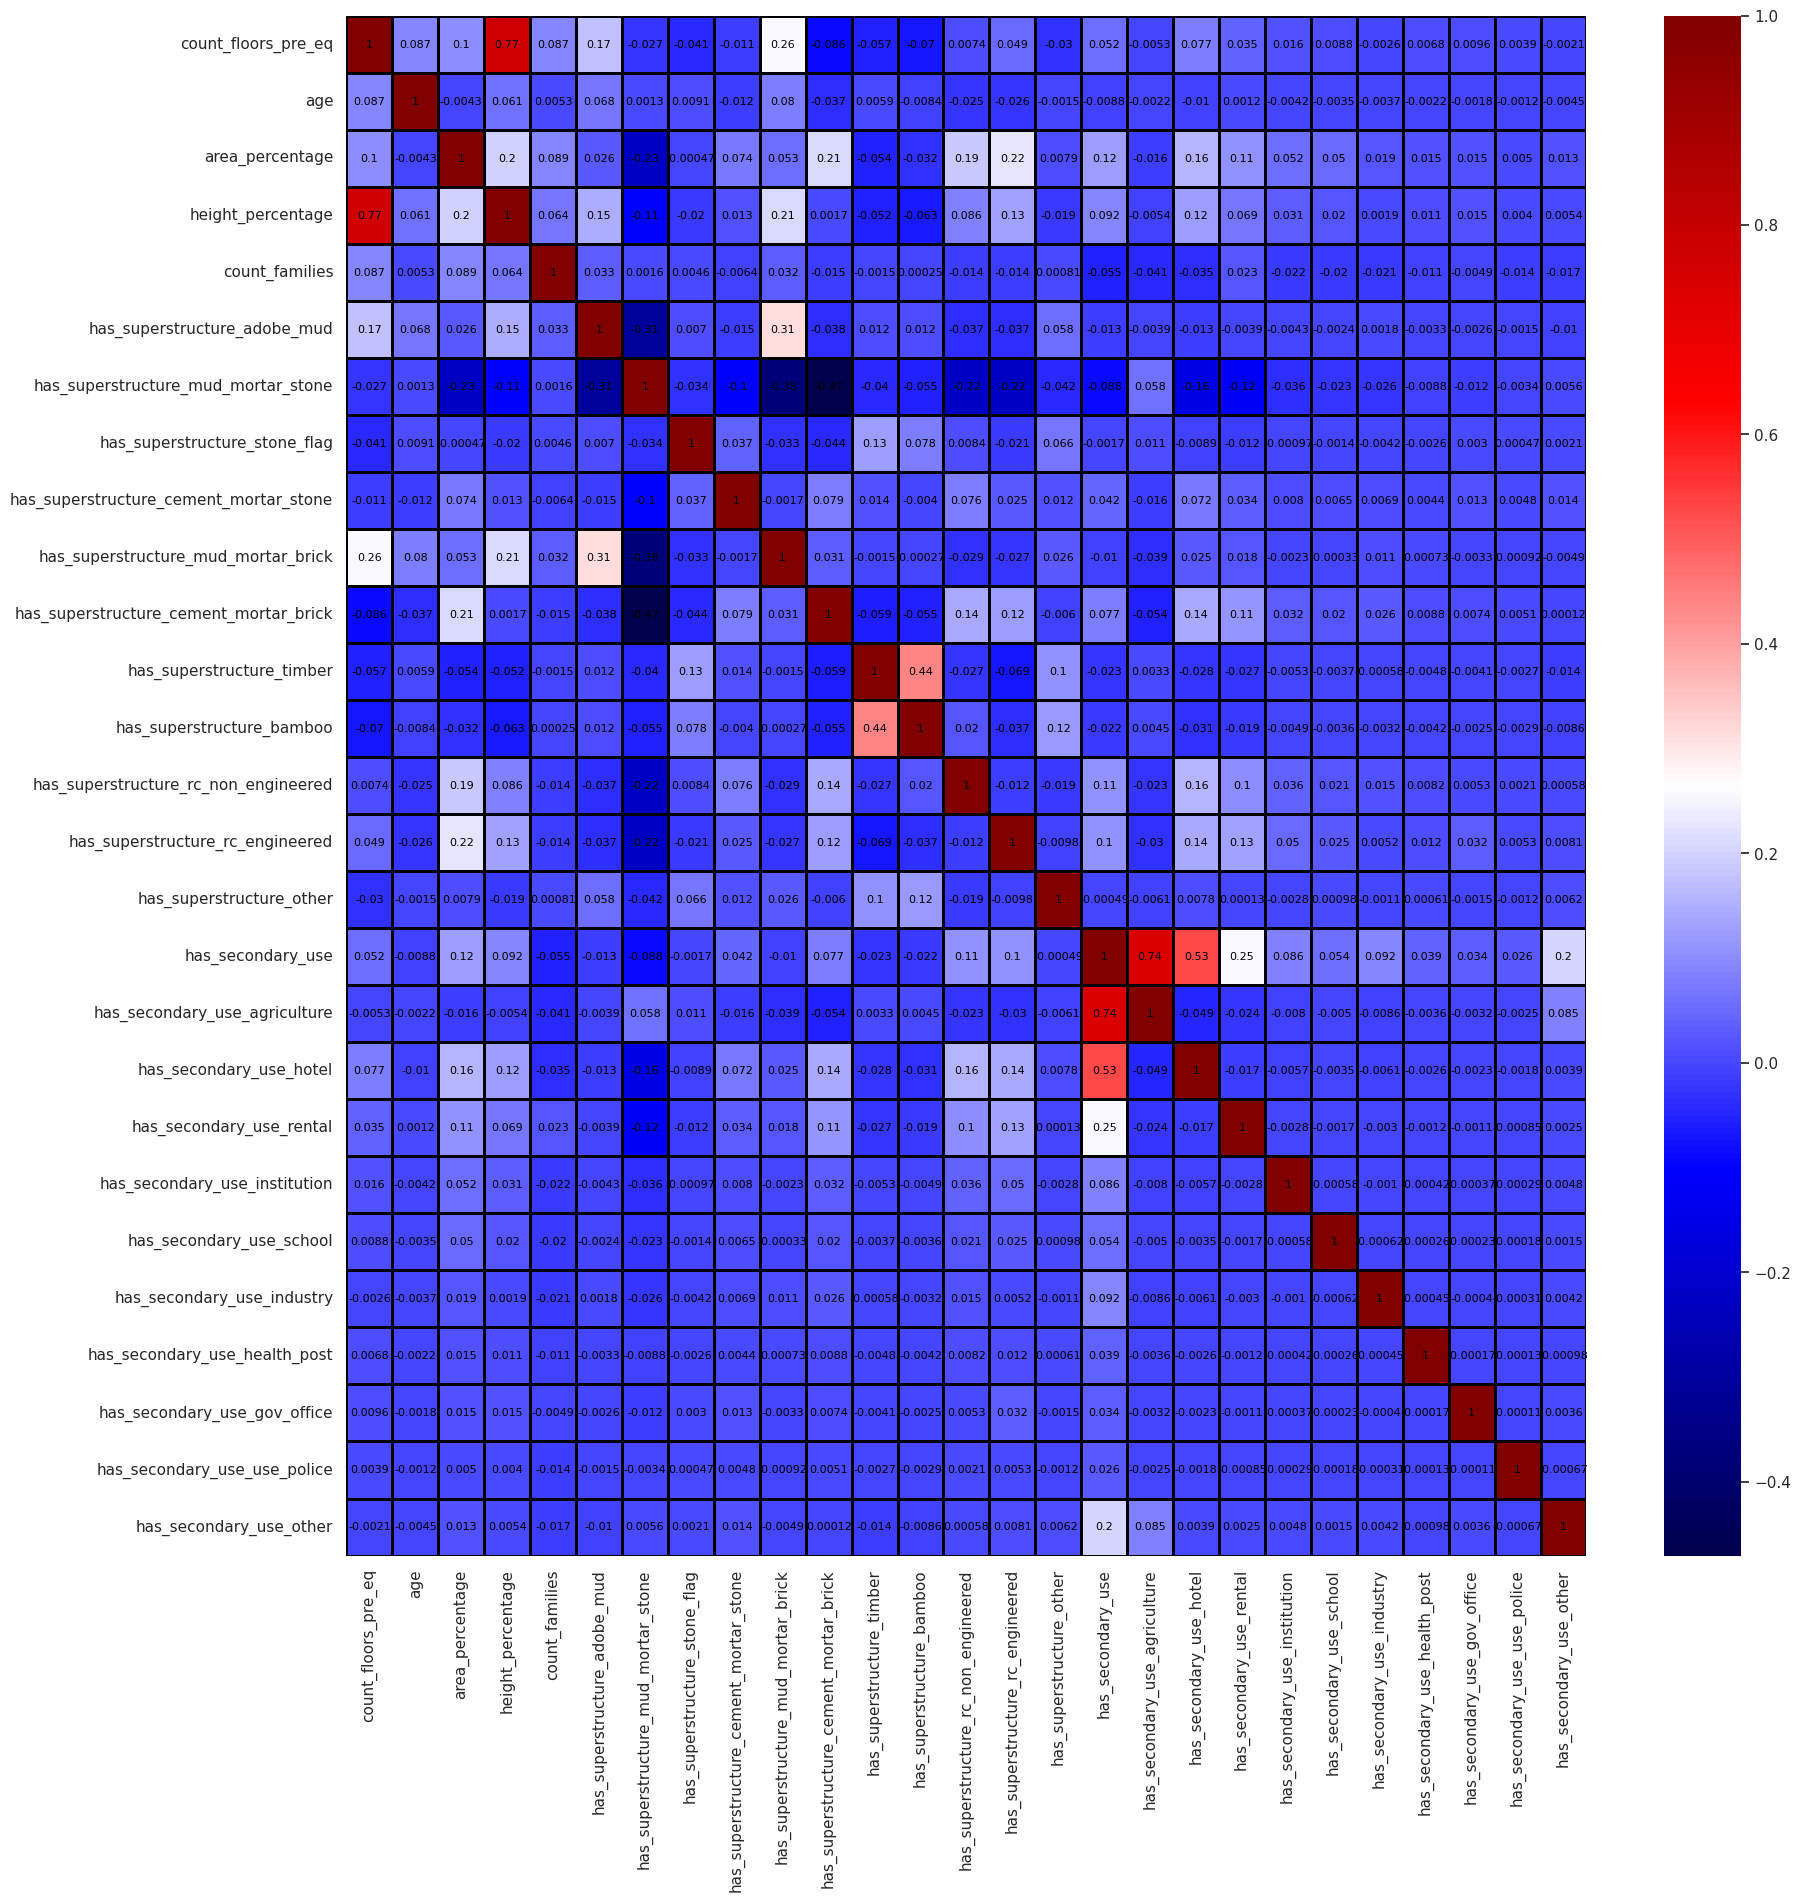

In [24]:
## Correlation matrix of numerical columns and binary_colums

corr_matrix = df_train[cols_num + cols_bin].corr()

fig = plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix,
           cmap='seismic',
           linewidth = 0.75,
           linecolor='black',
           cbar=True,
           annot=True,
           annot_kws={'size':8, 'color':'black'})

Takeaways:
- count_floor_pre_eq and height_percentage are positively correlated(0.77)
- Thus, **need to drop count_floor_pre_eq** because height_percentage is a more subtle parameter.

<Axes: xlabel='height_percentage', ylabel='count_floors_pre_eq'>

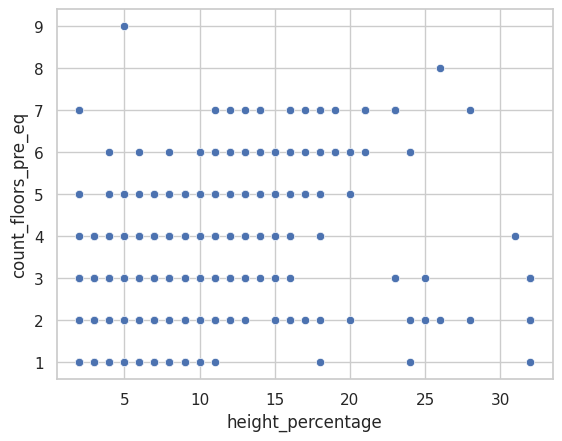

In [25]:
sns.scatterplot(data=df_train, x='height_percentage', y='count_floors_pre_eq')

In [26]:
df_train.head(5)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
1,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,0
2,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
3,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
4,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# lets see value counts of numerical variables

age_dist = df_train.age.value_counts()
age_dist

age
10     38896
15     36010
5      33697
20     32182
0      26041
25     24366
30     18028
35     10710
40     10559
50      7257
45      4711
60      3612
80      3055
55      2033
70      1975
995     1390
100     1364
65      1123
90      1085
85       847
75       512
95       414
120      180
150      142
200      106
110      100
105       89
125       37
115       21
130        9
140        9
180        7
160        6
170        6
175        5
135        5
190        3
145        3
195        2
165        2
155        1
185        1
Name: count, dtype: int64

In [28]:
# 
area_dist = df_train.area_percentage.value_counts()
area_dist

area_percentage
6      42013
7      36752
5      32724
8      28445
9      22199
       ...  
55         1
80         1
90         1
82         1
100        1
Name: count, Length: 84, dtype: int64

In [29]:
height_dist = df_train.height_percentage.value_counts()
height_dist

height_percentage
5     78513
6     46477
4     37763
7     35465
3     25957
8     13902
2      9305
9      5376
10     4492
11      917
12      907
13      759
15      292
16      179
32       75
18       71
14       66
20       33
21       13
23       11
17        9
19        7
24        4
25        3
26        2
28        2
31        1
Name: count, dtype: int64

In [30]:
floor_dist = df_train.count_floors_pre_eq.value_counts()
floor_dist

count_floors_pre_eq
2    156623
3     55617
1     40441
4      5424
5      2246
6       209
7        39
8         1
9         1
Name: count, dtype: int64

Takeaways:
- Discretize **age , area_percentage, height_percentage** because they have wide range of values.

# Data Proprocessing

In [31]:
total_entries_before = df_train.shape[0]
print("Total entries before preprocessing", total_entries_before)
print("Shape of df_train before",df_train.shape)

total_entries_before_test = df_test.shape[0]
print("Total test entries before preprocessing", total_entries_before_test)
print("Shape of df_test before",df_test.shape)

Total entries before preprocessing 260601
Shape of df_train before (260601, 38)
Total test entries before preprocessing 86868
Shape of df_test before (86868, 38)


### One-Hot encoding the string features

In [32]:
encoder = OneHotEncoder(cols = cols_obj,
                       return_df = True,
                       use_cat_names = True)

In [33]:
df_train_encoded = encoder.fit_transform(df_train)
print("Shape of data after OneHotEncoding :",df_train_encoded.shape)
df_train_encoded.head(10)

df_test_encoded = encoder.fit_transform(df_test)
print("Shape of test data after OneHotEncoding :",df_test_encoded.shape)

Shape of data after OneHotEncoding : (260601, 68)
Shape of test data after OneHotEncoding : (86868, 68)


### Discretizing the numeric variables

<Axes: xlabel='age_group_encoded'>

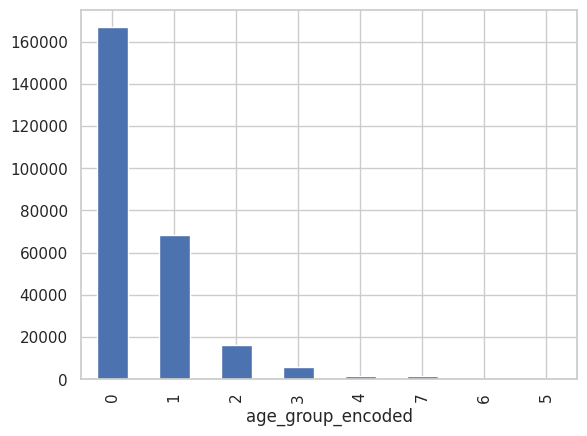

In [34]:
## Discretize Age

bins = [0, 25, 50, 75, 100, 125, 150, 175, 1000]
labels = ['0-24', '25-49', '50-74', '75-99',
         '100-124', '125-149', '150-174', '175+'] #8 bins

# Perform binning using bin list

df_train_encoded['age_group'] = \
pd.cut(df_train_encoded['age'], bins=bins,
      labels = labels, right=False)

# Map bins to integer values
df_train_encoded['age_group_encoded'] = \
df_train_encoded['age_group'].cat.codes

# Perform binning using bin list for test set
df_test_encoded['age_group'] = \
pd.cut(df_test_encoded['age'], bins=bins,
      labels = labels, right=False)
# Map bins to integer values for test set
df_test_encoded['age_group_encoded'] = \
df_test_encoded['age_group'].cat.codes


# plot age_group_encoded bar chart for train set
df_train_encoded.age_group_encoded.\
value_counts().plot(kind='bar')

In [35]:
# verify correct binning
age_vars = ['age_group_encoded', 'age_group', 'age']

df_train_encoded[age_vars].sample(10)

,age_group_encoded,age_group,age
97447,1,25-49,25
39845,0,0-24,5
67179,1,25-49,25
177896,0,0-24,0
82177,1,25-49,25
218142,0,0-24,5
239428,0,0-24,5
60934,2,50-74,70
142617,1,25-49,25
20057,0,0-24,20


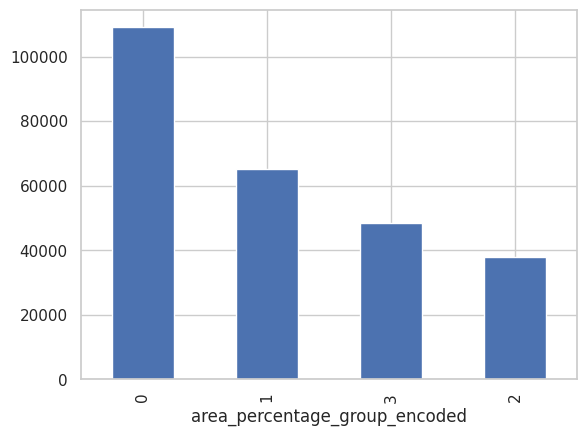

In [36]:
## Discretize area_percentage

bins = [0, 7, 9, 11, 101]
labels = ['0-6', '7-8', '9-10', '11-100'] #4 bins
       
# Perform binning using bin list

df_train_encoded['area_percentage_group'] = \
pd.cut(df_train_encoded['area_percentage'], bins=bins,
      labels = labels, right=False)

# Map bins to integer values
df_train_encoded['area_percentage_group_encoded'] = \
df_train_encoded['area_percentage_group'].cat.codes



# Perform binning using bin list for test set
df_test_encoded['area_percentage_group'] = \
pd.cut(df_test_encoded['area_percentage'], bins=bins,
      labels = labels, right=False)
# Map bins to integer values for test set
df_test_encoded['area_percentage_group_encoded'] = \
df_test_encoded['area_percentage_group'].cat.codes



df_train_encoded.area_percentage_group_encoded.\
value_counts().plot(kind='bar');

In [37]:
## Discretize height_percentage
df_train_encoded.height_percentage.describe()

count    260601.000000
mean          5.434365
std           1.918418
min           2.000000
25%           4.000000
50%           5.000000
75%           6.000000
max          32.000000
Name: height_percentage, dtype: float64

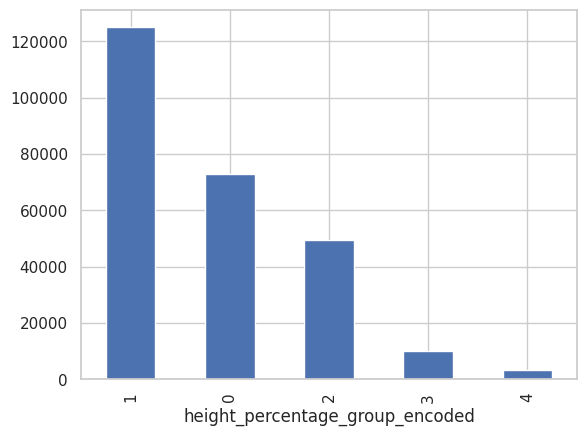

In [38]:
## Discretize height_percentage

bins = [0, 5, 7, 9, 11, 100]
labels = ['0-4', '5-6', '7-8', '9-10', '11+'] #5 bins
       
# Perform binning using bin list

df_train_encoded['height_percentage_group'] = \
pd.cut(df_train_encoded['height_percentage'], bins=bins,
      labels = labels, right=False)

# Map bins to integer values
df_train_encoded['height_percentage_group_encoded'] = \
df_train_encoded['height_percentage_group'].cat.codes



# Perform binning using bin list for test set
df_test_encoded['height_percentage_group'] = \
pd.cut(df_test_encoded['height_percentage'], bins=bins,
      labels = labels, right=False)

# Map bins to integer values for test set
df_test_encoded['height_percentage_group_encoded'] = \
df_test_encoded['height_percentage_group'].cat.codes



df_train_encoded.height_percentage_group_encoded.\
value_counts().plot(kind='bar');

In [39]:
print("Shape after OH and discretization:         ",df_train_encoded.shape)
print("Shape after OH and discretization for test:",df_test_encoded.shape)
df_train_encoded.head()

Shape after OH and discretization:          (260601, 74)
Shape after OH and discretization for test: (86868, 74)


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition_t,land_surface_condition_o,land_surface_condition_n,...,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,age_group,age_group_encoded,area_percentage_group,area_percentage_group_encoded,height_percentage_group,height_percentage_group_encoded
0,6,487,12198,2,30,6,5,1,0,0,...,0,0,0,0,25-49,1,0-6,0,5-6,1
1,8,900,2812,2,10,8,7,0,1,0,...,0,0,0,0,0-24,0,7-8,1,7-8,2
2,21,363,8973,2,10,5,5,1,0,0,...,0,0,0,0,0-24,0,0-6,0,5-6,1
3,22,418,10694,2,10,6,5,1,0,0,...,0,0,0,0,0-24,0,0-6,0,5-6,1
4,11,131,1488,3,30,8,9,1,0,0,...,0,0,0,0,25-49,1,7-8,1,9-10,3


In [40]:
## Dropping the columns which were discretized

df_train_encoded.drop(['age', 'age_group', 
                          'height_percentage', 'height_percentage_group',
                         'area_percentage', 'area_percentage_group'],
                     axis = 1,
                     inplace=True)

# dropping the same columns in TEST SET
df_test_encoded.drop(['age', 'age_group', 
                          'height_percentage', 'height_percentage_group',
                         'area_percentage', 'area_percentage_group'],
                     axis = 1,
                     inplace=True)

print("Shape after dropping discretized          :",df_train_encoded.shape)
print("Shape after dropping discretized for test :",df_test_encoded.shape)
#list(df_train_encoded)

Shape after dropping discretized          : (260601, 68)
Shape after dropping discretized for test : (86868, 68)


### Drop Low Variance Features

In [41]:
df_train_encoded.std()

geo_level_1_id                        8.033617
geo_level_2_id                      412.710734
geo_level_3_id                     3646.369645
count_floors_pre_eq                   0.727665
land_surface_condition_t              0.374082
                                      ...     
has_secondary_use_use_police          0.009394
has_secondary_use_other               0.071364
age_group_encoded                     0.925180
area_percentage_group_encoded         1.139522
height_percentage_group_encoded       0.858077
Length: 68, dtype: float64

In [42]:
# define standard deviation threshold
threshold = 0.1

# identify features below threshold

cols_to_drop = \
list(df_train_encoded.std()[df_train_encoded.std() < threshold].index.values)

print("Number of features with low std:", len(cols_to_drop))
print("Features with low standard deviation:", cols_to_drop)

Number of features with low std: 20
Features with low standard deviation: ['foundation_type_h', 'ground_floor_type_z', 'ground_floor_type_m', 'position_o', 'plan_configuration_s', 'plan_configuration_m', 'plan_configuration_c', 'plan_configuration_a', 'plan_configuration_n', 'plan_configuration_f', 'plan_configuration_o', 'legal_ownership_status_r', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']


In [43]:
# drop features with low standard deviation

df_train_interim = df_train_encoded.drop(cols_to_drop, axis=1)
df_test_interim = df_test_encoded.drop(cols_to_drop, axis=1)

print("Shape after dropping low variance         :",df_train_interim.shape)
print("Shape after dropping low variance for TEST:",df_test_interim.shape)
list(df_train_interim)

Shape after dropping low variance         : (260601, 48)
Shape after dropping low variance for TEST: (86868, 48)


['geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',
 'count_floors_pre_eq',
 'land_surface_condition_t',
 'land_surface_condition_o',
 'land_surface_condition_n',
 'foundation_type_r',
 'foundation_type_w',
 'foundation_type_i',
 'foundation_type_u',
 'roof_type_n',
 'roof_type_q',
 'roof_type_x',
 'ground_floor_type_f',
 'ground_floor_type_x',
 'ground_floor_type_v',
 'other_floor_type_q',
 'other_floor_type_x',
 'other_floor_type_j',
 'other_floor_type_s',
 'position_t',
 'position_s',
 'position_j',
 'plan_configuration_d',
 'plan_configuration_u',
 'plan_configuration_q',
 'has_superstructure_adobe_mud',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_stone_flag',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_timber',
 'has_superstructure_bamboo',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other',
 'legal_owne

### Drop Highly Correlated Features

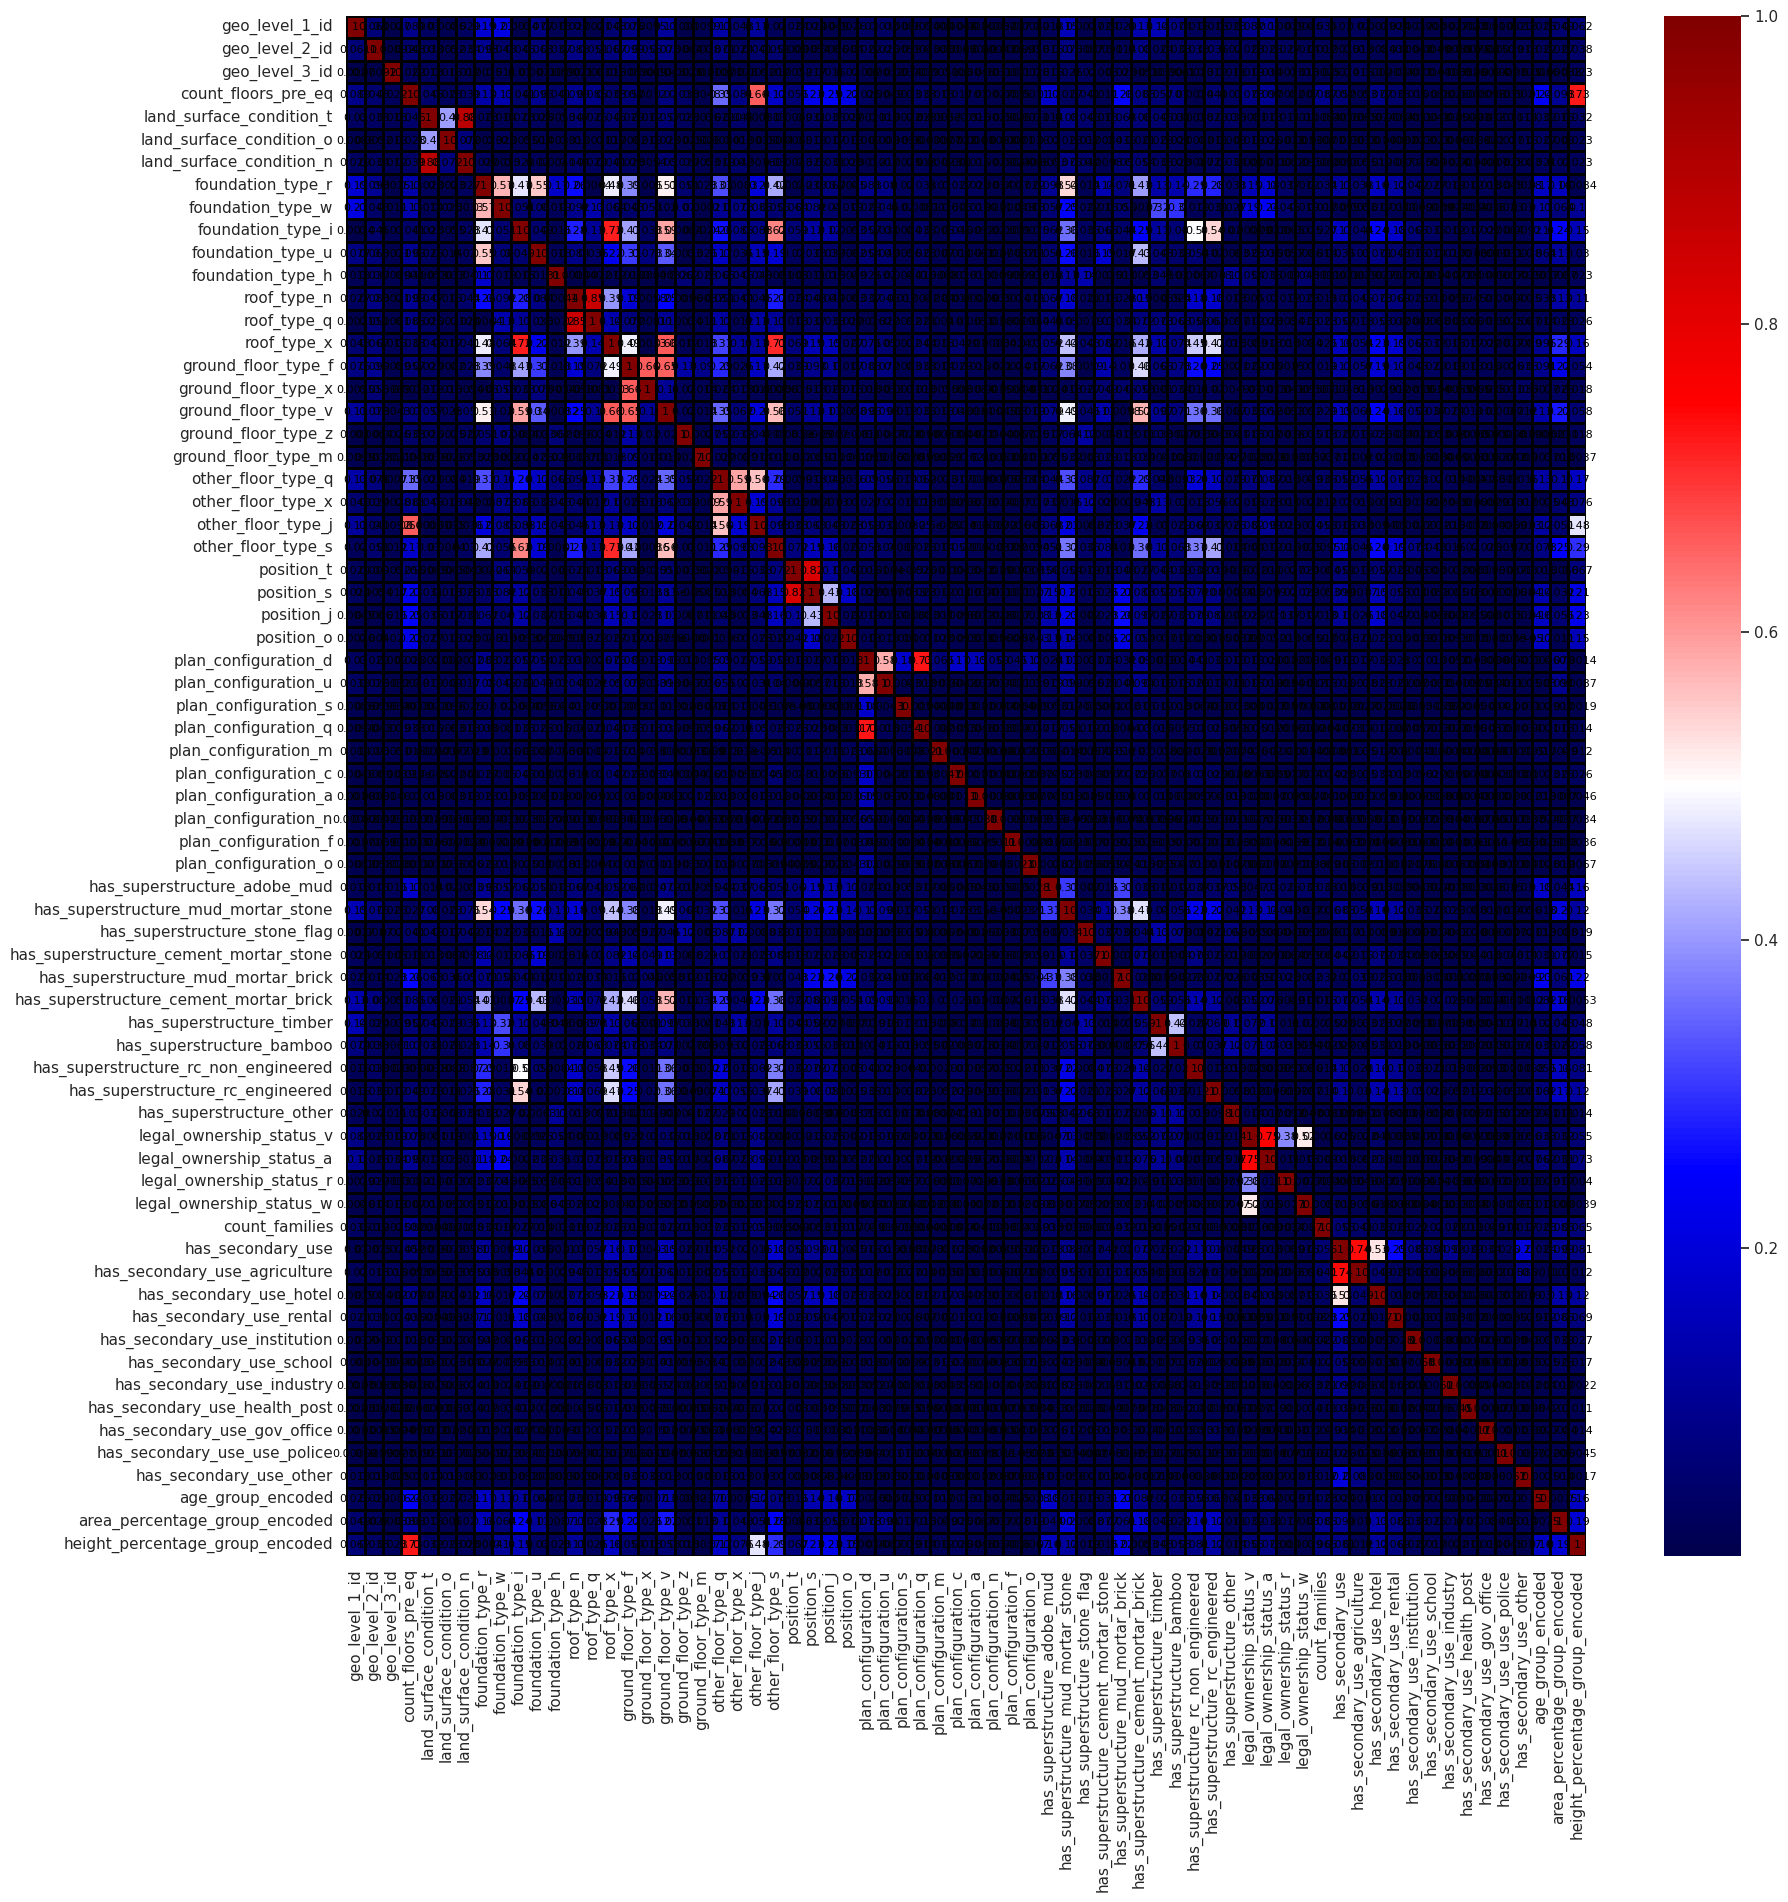

In [44]:
# inspect correlation
corr_matrix = df_train_encoded.corr().abs()

fig = plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix,
           cmap='seismic',
           linewidth = 0.75,
           linecolor='black',
           cbar=True,
           annot=True,
           annot_kws={'size':8, 'color':'black'});

In [45]:
# define correlation threshold
threshold = 0.75
corr_matrix = df_train_encoded.corr().abs()

high_corr_var = np.where(corr_matrix >= threshold)
high_corr_var = [(corr_matrix.index[x],
                 corr_matrix.columns[y],
                 round(corr_matrix.iloc[x,y],2))
                for x,y in zip(*high_corr_var)
                if x != y and x<y]

high_corr_var

[('land_surface_condition_t', 'land_surface_condition_n', 0.88),
 ('roof_type_n', 'roof_type_q', 0.85),
 ('position_t', 'position_s', 0.82)]

High correlation observed:
- 'land_surface_condition_t'and 'land_surface_condition_n':  0.88
- 'roof_type_n'and 'roof_type_q':  0.85
- 'position_t', 'position_s':  0.82

In [46]:
# Tidy up the output

record_collinear = pd.DataFrame(high_corr_var).\
rename(columns={0:'drop_feature',
               1:'corr_feature',
               2:'corr_values'})

record_collinear = record_collinear.\
sort_values(by='corr_values', ascending=False)

record_collinear = record_collinear.reset_index(drop=True)

record_collinear

,drop_feature,corr_feature,corr_values
0,land_surface_condition_t,land_surface_condition_n,0.88
1,roof_type_n,roof_type_q,0.85
2,position_t,position_s,0.82


In [47]:
cols_to_drop_corr = list(record_collinear['drop_feature'])
print(cols_to_drop_corr)

['land_surface_condition_t', 'roof_type_n', 'position_t']


In [48]:
# drop the highly correlated features

df_train_interim_2 = df_train_interim.drop(cols_to_drop_corr, axis=1)
df_test_interim_2 = df_test_interim.drop(cols_to_drop_corr, axis=1)

print("Shape after dropping highly correlated features         :",df_train_interim_2.shape)
print("Shape after dropping highly correlated features TEST SET:",df_test_interim_2.shape)
list(df_train_interim_2)

Shape after dropping highly correlated features         : (260601, 45)
Shape after dropping highly correlated features TEST SET: (86868, 45)


['geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',
 'count_floors_pre_eq',
 'land_surface_condition_o',
 'land_surface_condition_n',
 'foundation_type_r',
 'foundation_type_w',
 'foundation_type_i',
 'foundation_type_u',
 'roof_type_q',
 'roof_type_x',
 'ground_floor_type_f',
 'ground_floor_type_x',
 'ground_floor_type_v',
 'other_floor_type_q',
 'other_floor_type_x',
 'other_floor_type_j',
 'other_floor_type_s',
 'position_s',
 'position_j',
 'plan_configuration_d',
 'plan_configuration_u',
 'plan_configuration_q',
 'has_superstructure_adobe_mud',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_stone_flag',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_timber',
 'has_superstructure_bamboo',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other',
 'legal_ownership_status_v',
 'legal_ownership_status_a',
 'legal_owners

In [49]:
df_test_interim_2 = df_test_interim[list(df_train_interim_2)]
#list(df_test_interim_2)

In [50]:
df_train_unscaled = df_train_interim_2
df_test_unscaled = df_test_interim_2
df_train_unscaled.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,land_surface_condition_o,land_surface_condition_n,foundation_type_r,foundation_type_w,foundation_type_i,foundation_type_u,...,legal_ownership_status_v,legal_ownership_status_a,legal_ownership_status_w,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,age_group_encoded,area_percentage_group_encoded,height_percentage_group_encoded
0,6,487,12198,2,0,0,1,0,0,0,...,1,0,0,1,0,0,0,1,0,1
1,8,900,2812,2,1,0,1,0,0,0,...,1,0,0,1,0,0,0,0,1,2
2,21,363,8973,2,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
3,22,418,10694,2,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
4,11,131,1488,3,0,0,1,0,0,0,...,1,0,0,1,0,0,0,1,1,3


In [51]:
# SCALE data

scaler = StandardScaler()
scaler.fit(df_train_unscaled)
train_scaled = scaler.transform(df_train_unscaled) #not a dataframe anymore. now an array
test_scaled = scaler.transform(df_test_unscaled)
train_scaled[1,:]

array([-0.73445934,  0.48199788, -0.9450174 , -0.17827372,  5.50793079,
       -0.39730468,  0.43462037, -0.24816267, -0.20569948, -0.24059767,
       -0.55622681, -0.25731371, -2.02771488,  3.07824298, -0.32280659,
        0.75941113, -0.44730317, -0.42483256, -0.21997318,  0.53807938,
       -0.23174106,  0.20519229, -0.11916835, -0.14943071, -0.31187717,
        0.55897054, -0.18855446, -0.13628447, -0.27044166, -0.28529769,
       -0.58502938, -0.30481066, -0.21091376, -0.12694515, -0.12333915,
        0.19622278, -0.14699709, -0.10187751,  0.03836475, -0.35492784,
       -0.26231246, -0.18653734, -0.56815677, -0.08672209,  1.13798123])

In [52]:
# Convert train_scaled array to a dataframe
df_train_scaled = pd.DataFrame(train_scaled, columns=list(df_train_unscaled)) 
df_test_scaled = pd.DataFrame(test_scaled, columns=list(df_train_unscaled)) 
df_train_scaled.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,land_surface_condition_o,land_surface_condition_n,foundation_type_r,foundation_type_w,foundation_type_i,foundation_type_u,...,legal_ownership_status_v,legal_ownership_status_a,legal_ownership_status_w,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,age_group_encoded,area_percentage_group_encoded,height_percentage_group_encoded
0,-0.983414,-0.518705,1.629055,-0.178274,-0.181556,-0.397305,0.43462,-0.248163,-0.205699,-0.240598,...,0.196223,-0.146997,-0.101878,0.038365,-0.354928,-0.262312,-0.186537,0.512716,-0.964284,-0.027418
1,-0.734459,0.481998,-0.945017,-0.178274,5.507931,-0.397305,0.43462,-0.248163,-0.205699,-0.240598,...,0.196223,-0.146997,-0.101878,0.038365,-0.354928,-0.262312,-0.186537,-0.568157,-0.086722,1.137981
2,0.883744,-0.819158,0.744612,-0.178274,-0.181556,-0.397305,0.43462,-0.248163,-0.205699,-0.240598,...,0.196223,-0.146997,-0.101878,0.038365,-0.354928,-0.262312,-0.186537,-0.568157,-0.964284,-0.027418
3,1.008221,-0.685893,1.216589,-0.178274,-0.181556,-0.397305,0.43462,-0.248163,-0.205699,-0.240598,...,0.196223,-0.146997,-0.101878,0.038365,-0.354928,-0.262312,-0.186537,-0.568157,-0.964284,-0.027418
4,-0.361028,-1.381296,-1.308119,1.195989,-0.181556,-0.397305,0.43462,-0.248163,-0.205699,-0.240598,...,0.196223,-0.146997,-0.101878,0.038365,-0.354928,-0.262312,-0.186537,0.512716,-0.086722,2.303380


### PCA of the scaled data

In [53]:
# Apply PCA to scaled data
pca = PCA(n_components=2)  
train_pca = pca.fit_transform(df_train_scaled)
test_pca = pca.fit_transform(df_test_scaled)

# Save the PCA-transformed data into a new DataFrame
df_train_pca = pd.DataFrame(data=train_pca, columns=['PC1', 'PC2'])
df_test_pca = pd.DataFrame(data=test_pca, columns=['PC1', 'PC2'])

### Save all data

In [54]:
df_train_unscaled.to_pickle("/kaggle/working/df_train_unscaled.pickle")
df_test_unscaled.to_pickle("/kaggle/working/df_test_unscaled.pickle")

df_train_scaled.to_pickle("/kaggle/working/df_train_scaled.pickle")
df_test_scaled.to_pickle("/kaggle/working/df_test_scaled.pickle")

# Save the PCA-transformed DataFrame
df_train_pca.to_pickle('/kaggle/working/df_train_pca.pickle')
df_test_pca.to_pickle('/kaggle/working/df_test_pca.pickle')

# Load the data

Unscaled data for these algorithms
- decision trees
- random forest
- naive bayes
- XGBoost
- LightBGM
- Ensemble methods(Bagging)

Scaled data for these algorithms
- KNN
- SVM
- ANN

In [55]:
# Load data from pickle file into a DataFrame
df_train_scaled = pd.read_pickle("/kaggle/working/df_train_scaled.pickle")
df_test_scaled = pd.read_pickle("/kaggle/working/df_test_scaled.pickle")
df_train_unscaled = pd.read_pickle("/kaggle/working/df_train_unscaled.pickle")
df_test_unscaled = pd.read_pickle("/kaggle/working/df_test_unscaled.pickle")


# verify loaded properly
print("Shape of train set loaded scaled:", df_train_scaled.shape)
print("Shape of test set loaded scaled :", df_test_scaled.shape)
print("Shape of train set loaded unscaled:", df_train_scaled.shape)
print("Shape of test set loaded unscaled :", df_test_scaled.shape)
df_train_scaled.head()

Shape of train set loaded scaled: (260601, 45)
Shape of test set loaded scaled : (86868, 45)
Shape of train set loaded unscaled: (260601, 45)
Shape of test set loaded unscaled : (86868, 45)


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,land_surface_condition_o,land_surface_condition_n,foundation_type_r,foundation_type_w,foundation_type_i,foundation_type_u,...,legal_ownership_status_v,legal_ownership_status_a,legal_ownership_status_w,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,age_group_encoded,area_percentage_group_encoded,height_percentage_group_encoded
0,-0.983414,-0.518705,1.629055,-0.178274,-0.181556,-0.397305,0.43462,-0.248163,-0.205699,-0.240598,...,0.196223,-0.146997,-0.101878,0.038365,-0.354928,-0.262312,-0.186537,0.512716,-0.964284,-0.027418
1,-0.734459,0.481998,-0.945017,-0.178274,5.507931,-0.397305,0.43462,-0.248163,-0.205699,-0.240598,...,0.196223,-0.146997,-0.101878,0.038365,-0.354928,-0.262312,-0.186537,-0.568157,-0.086722,1.137981
2,0.883744,-0.819158,0.744612,-0.178274,-0.181556,-0.397305,0.43462,-0.248163,-0.205699,-0.240598,...,0.196223,-0.146997,-0.101878,0.038365,-0.354928,-0.262312,-0.186537,-0.568157,-0.964284,-0.027418
3,1.008221,-0.685893,1.216589,-0.178274,-0.181556,-0.397305,0.43462,-0.248163,-0.205699,-0.240598,...,0.196223,-0.146997,-0.101878,0.038365,-0.354928,-0.262312,-0.186537,-0.568157,-0.964284,-0.027418
4,-0.361028,-1.381296,-1.308119,1.195989,-0.181556,-0.397305,0.43462,-0.248163,-0.205699,-0.240598,...,0.196223,-0.146997,-0.101878,0.038365,-0.354928,-0.262312,-0.186537,0.512716,-0.086722,2.303380


In [56]:
df_train_unscaled.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,land_surface_condition_o,land_surface_condition_n,foundation_type_r,foundation_type_w,foundation_type_i,foundation_type_u,...,legal_ownership_status_v,legal_ownership_status_a,legal_ownership_status_w,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,age_group_encoded,area_percentage_group_encoded,height_percentage_group_encoded
0,6,487,12198,2,0,0,1,0,0,0,...,1,0,0,1,0,0,0,1,0,1
1,8,900,2812,2,1,0,1,0,0,0,...,1,0,0,1,0,0,0,0,1,2
2,21,363,8973,2,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
3,22,418,10694,2,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
4,11,131,1488,3,0,0,1,0,0,0,...,1,0,0,1,0,0,0,1,1,3


# Baseline: KNN and SVC with Scaled data

In [57]:
X = df_train_scaled.values # Features
y = df_train_labels['damage_grade'].values

In [58]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [59]:
# Dataframe to store results of predictions
results = pd.DataFrame(y_test, columns=["y_test"])
results

,y_test
0,3
1,2
2,2
3,2
4,3
...,...
52116,2
52117,2
52118,2
52119,2


In [60]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

### Model evaluation

In [61]:
# Model evaluation
def model_eval(model_name, y_test, y_pred_org):
    accuracy = accuracy_score(y_test, y_pred_org)
    f1  = f1_score(y_test, y_pred_org, average='micro')
    precision = precision_score(y_test, y_pred_org, average='micro')
    recall = recall_score(y_test, y_pred_org, average='micro')
    print(f"{model_name} Accuracy : {accuracy}")
    print(f"{model_name} F1       : {f1}")
    print(f"{model_name} precision: {precision}")
    print(f"{model_name} recall   : {recall}")
    
    return [model_name, accuracy, f1, precision, recall]

In [62]:
def append_results(df, model_eval):
    
    data = {'model': [model_eval[0]],
            'accuracy': [model_eval[1]],
            'f1_score':[model_eval[2]],
            'precision':[model_eval[3]],
            'recall':[model_eval[4]]}
    
    df = pd.concat([df, pd.DataFrame(data)], ignore_index=True)
    
    return df

### KNN Baseline

In [63]:
# KNN model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train_encoded)

KNeighborsClassifier()

In [64]:
knn_1_y_pred = knn.predict(X_test)
# Decode predictions back to original labels
knn_1_y_pred_org = label_encoder.inverse_transform(knn_1_y_pred)
knn_1_eval = model_eval("KNN", y_test, knn_1_y_pred_org)

KNN Accuracy : 0.6341589762283917
KNN F1       : 0.6341589762283917
KNN precision: 0.6341589762283917
KNN recall   : 0.6341589762283917


In [65]:
# Define dataframe to store metrics results

columns = ['model', 'accuracy', 'f1_score', 'precision', 'recall']

# Create an empty DataFrame with defined columns
df_metrics = pd.DataFrame(columns=columns)

df_metrics

,model,accuracy,f1_score,precision,recall


In [66]:
df_metrics = append_results(df = df_metrics, model_eval = knn_1_eval)
df_metrics

,model,accuracy,f1_score,precision,recall
0,KNN,0.634159,0.634159,0.634159,0.634159


# KNN Baseline using Truncated SVD

In [68]:
# Use Truncated SVD for dimensionality reduction on sparse matrices
n_components = 10  
svd = TruncatedSVD(n_components=n_components)

In [69]:
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

In [70]:
## KNN with Truncated SVD 
## n_components= 10

# Create and train model with Truncated SVD-transformed data
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_svd, y_train_encoded)

# Make predictions
knn_y_pred = knn_model.predict(X_test_svd)

# Decode predictions back to original labels
knn_y_pred_org = label_encoder.inverse_transform(knn_y_pred)
knn_eval = model_eval("KNN", y_test, knn_y_pred_org)

# Append metrics dataframe 
df_metrics = append_results(df = df_metrics, model_eval = knn_eval)
print(df_metrics)

# Append results dataframe to see predictions
results["knn_y_pred_org"] = knn_y_pred_org
results[:10]

KNN Accuracy : 0.6292857005813396
KNN F1       : 0.6292857005813396
KNN precision: 0.6292857005813396
KNN recall   : 0.6292857005813396
  model  accuracy  f1_score  precision    recall
0   KNN  0.634159  0.634159   0.634159  0.634159
1   KNN  0.629286  0.629286   0.629286  0.629286


,y_test,knn_y_pred_org
0,3,2
1,2,2
2,2,3
3,2,3
4,3,3
5,3,2
6,3,2
7,2,2
8,2,2
9,2,2


# SVC Baseline with Truncated SVD

In [71]:
# Create and train model with Truncated SVD-transformed data
svc_model = SVC()
svc_model.fit(X_train_svd, y_train_encoded)

# Make predictions
svc_y_pred = svc_model.predict(X_test_svd)

# Decode predictions back to original labels
svc_y_pred_org = label_encoder.inverse_transform(svc_y_pred)
svc_eval = model_eval("SVC", y_test, svc_y_pred_org)

# Append metrics dataframe 
df_metrics = append_results(df = df_metrics, model_eval = svc_eval)
print(df_metrics)

# Append results dataframe to see predictions
results["svc_y_pred_org"] = svc_y_pred_org
results[:10]

SVC Accuracy : 0.5886303025651849
SVC F1       : 0.5886303025651849
SVC precision: 0.5886303025651849
SVC recall   : 0.5886303025651849
  model  accuracy  f1_score  precision    recall
0   KNN  0.634159  0.634159   0.634159  0.634159
1   KNN  0.629286  0.629286   0.629286  0.629286
2   SVC  0.588630  0.588630   0.588630  0.588630


,y_test,knn_y_pred_org,svc_y_pred_org
0,3,2,2
1,2,2,2
2,2,3,2
3,2,3,2
4,3,3,2
5,3,2,2
6,3,2,2
7,2,2,2
8,2,2,2
9,2,2,2


In [72]:
## SAVE Progress
with open('/kaggle/working/knn_baseline_svd.pkl', 'wb') as model_file:
    pickle.dump(knn_model, model_file)
    
with open('/kaggle/working/svc_baseline_svd.pkl', 'wb') as model_file:
    pickle.dump(svc_model, model_file)

#df_metrics.to_pickle('/kaggle/working/df_metrics.pickle')
#results.to_pickle('/kaggle/working/results.pickle')


In [73]:
# Load the pickled DataFrame
    
#df_metrics_fork1 = pd.read_pickle("/kaggle/input/svc-knn-svd-baseline/df_metrics.pickle")
#results_fork1 = pd.read_pickle("/kaggle/input/svc-knn-svd-baseline/results.pickle")
#df_train_scaled = pd.read_pickle("/kaggle/input/svc-knn-svd-baseline/df_train_scaled.pickle")
#df_test_scaled = pd.read_pickle("/kaggle/input/svc-knn-svd-baseline/df_test_scaled.pickle")


In [74]:
## Basic steps to reach to svd dataset

# X = df_train_scaled.values # Features
# y = df_train_labels['damage_grade'].values

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.fit_transform(y_test)

# # Use Truncated SVD for dimensionality reduction on sparse matrices
# n_components = 10  
# svd = TruncatedSVD(n_components=n_components)

# X_train_svd = svd.fit_transform(X_train)
# X_test_svd = svd.transform(X_test)

## ran model_eval(model_name, y_test, y_pred_org) 
## and append_results(df, model_eval) functions

# Decision trees baseline with SVD=10

In [75]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train_svd, y_train_encoded)

# Make predictions
tree_y_pred = tree_model.predict(X_test_svd)

# Decode predictions back to original labels
tree_y_pred_org = label_encoder.inverse_transform(tree_y_pred)
tree_eval = model_eval("Tree", y_test, tree_y_pred_org)

# Append metrics dataframe 
df_metrics = append_results(df = df_metrics, model_eval = tree_eval)
print(df_metrics)

# Append results dataframe to see predictions
results["tree_y_pred_org"] = tree_y_pred_org
results[:10]


Tree Accuracy : 0.600813491682815
Tree F1       : 0.600813491682815
Tree precision: 0.600813491682815
Tree recall   : 0.600813491682815
  model  accuracy  f1_score  precision    recall
0   KNN  0.634159  0.634159   0.634159  0.634159
1   KNN  0.629286  0.629286   0.629286  0.629286
2   SVC  0.588630  0.588630   0.588630  0.588630
3  Tree  0.600813  0.600813   0.600813  0.600813


,y_test,knn_y_pred_org,svc_y_pred_org,tree_y_pred_org
0,3,2,2,2
1,2,2,2,2
2,2,3,2,1
3,2,3,2,3
4,3,3,2,3
5,3,2,2,2
6,3,2,2,2
7,2,2,2,1
8,2,2,2,2
9,2,2,2,2


# Random Forest Baseline with SVD(n=10)

In [76]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_svd, y_train_encoded)

# Make predictions
rf_y_pred = rf_model.predict(X_test_svd)

# Decode predictions back to original labels
rf_y_pred_org = label_encoder.inverse_transform(rf_y_pred)
rf_eval = model_eval("RF", y_test, rf_y_pred_org)

# Append metrics dataframe 
df_metrics = append_results(df = df_metrics, model_eval = rf_eval)
print(df_metrics)

# Append results dataframe to see predictions
results["rf_y_pred_org"] = rf_y_pred_org
results[:10]


RF Accuracy : 0.6481840333071123
RF F1       : 0.6481840333071123
RF precision: 0.6481840333071123
RF recall   : 0.6481840333071123
  model  accuracy  f1_score  precision    recall
0   KNN  0.634159  0.634159   0.634159  0.634159
1   KNN  0.629286  0.629286   0.629286  0.629286
2   SVC  0.588630  0.588630   0.588630  0.588630
3  Tree  0.600813  0.600813   0.600813  0.600813
4    RF  0.648184  0.648184   0.648184  0.648184


,y_test,knn_y_pred_org,svc_y_pred_org,tree_y_pred_org,rf_y_pred_org
0,3,2,2,2,2
1,2,2,2,2,2
2,2,3,2,1,3
3,2,3,2,3,3
4,3,3,2,3,3
5,3,2,2,2,2
6,3,2,2,2,2
7,2,2,2,1,2
8,2,2,2,2,2
9,2,2,2,2,2


Save decision trees and random forest models results

In [77]:
with open('/kaggle/working/tree_baseline_svd.pkl', 'wb') as model_file:
    pickle.dump(tree_model, model_file)
    
with open('/kaggle/working/rf_baseline_svd.pkl', 'wb') as model_file:
    pickle.dump(rf_model, model_file)

#df_metrics_fork1.to_pickle('/kaggle/working/df_metrics_fork1.pickle')
#results_fork1.to_pickle('/kaggle/working/results_fork1.pickle')

# Gaussian Naive Bayes with SVD = 10

In [79]:
# Naive Bayes Classifier
nb_model = GaussianNB()
nb_model.fit(X_train_svd, y_train_encoded)

# Make predictions
nb_y_pred = nb_model.predict(X_test_svd)

# Decode predictions back to original labels
nb_y_pred_org = label_encoder.inverse_transform(nb_y_pred)
nb_eval = model_eval("NB", y_test, nb_y_pred_org)

# Append metrics dataframe
df_metrics = append_results(df=df_metrics, model_eval=nb_eval)
print(df_metrics)

# Append results dataframe to see predictions
results["nb_y_pred_org"] = nb_y_pred_org
print(results[:10])

NB Accuracy : 0.4420291245371347
NB F1       : 0.4420291245371347
NB precision: 0.4420291245371347
NB recall   : 0.4420291245371347
  model  accuracy  f1_score  precision    recall
0   KNN  0.634159  0.634159   0.634159  0.634159
1   KNN  0.629286  0.629286   0.629286  0.629286
2   SVC  0.588630  0.588630   0.588630  0.588630
3  Tree  0.600813  0.600813   0.600813  0.600813
4    RF  0.648184  0.648184   0.648184  0.648184
5    NB  0.442029  0.442029   0.442029  0.442029
   y_test  knn_y_pred_org  svc_y_pred_org  tree_y_pred_org  rf_y_pred_org  \
0       3               2               2                2              2   
1       2               2               2                2              2   
2       2               3               2                1              3   
3       2               3               2                3              3   
4       3               3               2                3              3   
5       3               2               2                2     

# XGB Baseline with SVD=10

In [80]:
# XGBoost Classifier
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_svd, y_train_encoded)

# Make predictions
xgb_y_pred = xgb_model.predict(X_test_svd)

# Decode predictions back to original labels
xgb_y_pred_org = label_encoder.inverse_transform(xgb_y_pred)
xgb_eval = model_eval("XGB", y_test, xgb_y_pred_org)

# Append metrics dataframe 
df_metrics = append_results(df = df_metrics, model_eval = xgb_eval)
print(df_metrics)

# Append results dataframe to see predictions
results["xgb_y_pred_org"] = xgb_y_pred_org
results[:10]

XGB Accuracy : 0.6241054469407724
XGB F1       : 0.6241054469407724
XGB precision: 0.6241054469407724
XGB recall   : 0.6241054469407724
  model  accuracy  f1_score  precision    recall
0   KNN  0.634159  0.634159   0.634159  0.634159
1   KNN  0.629286  0.629286   0.629286  0.629286
2   SVC  0.588630  0.588630   0.588630  0.588630
3  Tree  0.600813  0.600813   0.600813  0.600813
4    RF  0.648184  0.648184   0.648184  0.648184
5    NB  0.442029  0.442029   0.442029  0.442029
6   XGB  0.624105  0.624105   0.624105  0.624105


,y_test,knn_y_pred_org,svc_y_pred_org,tree_y_pred_org,rf_y_pred_org,nb_y_pred_org,xgb_y_pred_org
0,3,2,2,2,2,1,2
1,2,2,2,2,2,1,2
2,2,3,2,1,3,2,2
3,2,3,2,3,3,2,3
4,3,3,2,3,3,3,2
5,3,2,2,2,2,3,2
6,3,2,2,2,2,3,2
7,2,2,2,1,2,1,2
8,2,2,2,2,2,3,2
9,2,2,2,2,2,2,2


In [81]:
# Append results dataframe to see predictions
#results_fork1["xgb_y_pred_org"] = xgb_y_pred_org
#results_fork1[:10]

# LightGBM Baseline with SVD n=10

In [82]:
# lgbm Classifier
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train_svd, y_train_encoded)

# Make predictions
lgbm_y_pred = lgbm_model.predict(X_test_svd)

# Decode predictions back to original labels
lgbm_y_pred_org = label_encoder.inverse_transform(lgbm_y_pred)
lgbm_eval = model_eval("LGBM", y_test, lgbm_y_pred_org)

# Append metrics dataframe 
df_metrics = append_results(df = df_metrics, model_eval = lgbm_eval)
print(df_metrics)

# Append results dataframe to see predictions
results["lgbm_y_pred_org"] = lgbm_y_pred_org
results[:10]

LGBM Accuracy : 0.613821684158017
LGBM F1       : 0.613821684158017
LGBM precision: 0.613821684158017
LGBM recall   : 0.613821684158017
  model  accuracy  f1_score  precision    recall
0   KNN  0.634159  0.634159   0.634159  0.634159
1   KNN  0.629286  0.629286   0.629286  0.629286
2   SVC  0.588630  0.588630   0.588630  0.588630
3  Tree  0.600813  0.600813   0.600813  0.600813
4    RF  0.648184  0.648184   0.648184  0.648184
5    NB  0.442029  0.442029   0.442029  0.442029
6   XGB  0.624105  0.624105   0.624105  0.624105
7  LGBM  0.613822  0.613822   0.613822  0.613822


,y_test,knn_y_pred_org,svc_y_pred_org,tree_y_pred_org,rf_y_pred_org,nb_y_pred_org,xgb_y_pred_org,lgbm_y_pred_org
0,3,2,2,2,2,1,2,2
1,2,2,2,2,2,1,2,2
2,2,3,2,1,3,2,2,2
3,2,3,2,3,3,2,3,2
4,3,3,2,3,3,3,2,2
5,3,2,2,2,2,3,2,2
6,3,2,2,2,2,3,2,2
7,2,2,2,1,2,1,2,2
8,2,2,2,2,2,3,2,2
9,2,2,2,2,2,2,2,2


**Takeaways:**

The micro-averaged F1- scores provide the following conclusions:

- Random forest with truncated svd(10) seems highest (0.648) 
- Not much difference with KNN and  with KNN on truncated svd (0.634 amd 0.627).
- XGB with truncated svd( 0.624) and LightGBM (0.614) seems promising.

**Decision:**

- see Random forest, XGB, LightBGM results on whole X_train and X_test(no svd truncation). 


Save results of : Naive Bayes, XGB, and LightGBM

In [83]:
with open('/kaggle/working/xgb_baseline_svd.pkl', 'wb') as model_file:
    pickle.dump(xgb_model, model_file)
    
with open('/kaggle/working/lgbm_baseline_svd.pkl', 'wb') as model_file:
    pickle.dump(lgbm_model, model_file)
    
with open('/kaggle/working/nb_baseline_svd.pkl', 'wb') as model_file:
    pickle.dump(nb_model, model_file)

#df_metrics_fork1.to_pickle('/kaggle/working/df_metrics_fork1.pickle')
#results_fork1.to_pickle('/kaggle/working/results_fork1.pickle')

# includes results of tree, rf from first run
# and Naive Bayes, XGB, Lightbgm from second run

# Random Forest on whole data(no svd)

In [84]:
rf_model_whole = RandomForestClassifier(random_state=42)
rf_model_whole.fit(X_train, y_train_encoded)

# Make predictions
rf_y_pred_whole = rf_model_whole.predict(X_test)

# Decode predictions back to original labels
rf_y_pred_org_whole = label_encoder.inverse_transform(rf_y_pred_whole)
rf_eval_whole = model_eval("RF_Whole", y_test, rf_y_pred_org_whole)

# Append metrics dataframe 
df_metrics = append_results(df = df_metrics, model_eval = rf_eval_whole)
print(df_metrics)

# Append results dataframe to see predictions
results["rf_y_pred_org_whole"] = rf_y_pred_org_whole
results[:10]

RF_Whole Accuracy : 0.7100592851249976
RF_Whole F1       : 0.7100592851249976
RF_Whole precision: 0.7100592851249976
RF_Whole recall   : 0.7100592851249976
      model  accuracy  f1_score  precision    recall
0       KNN  0.634159  0.634159   0.634159  0.634159
1       KNN  0.629286  0.629286   0.629286  0.629286
2       SVC  0.588630  0.588630   0.588630  0.588630
3      Tree  0.600813  0.600813   0.600813  0.600813
4        RF  0.648184  0.648184   0.648184  0.648184
5        NB  0.442029  0.442029   0.442029  0.442029
6       XGB  0.624105  0.624105   0.624105  0.624105
7      LGBM  0.613822  0.613822   0.613822  0.613822
8  RF_Whole  0.710059  0.710059   0.710059  0.710059


,y_test,knn_y_pred_org,svc_y_pred_org,tree_y_pred_org,rf_y_pred_org,nb_y_pred_org,xgb_y_pred_org,lgbm_y_pred_org,rf_y_pred_org_whole
0,3,2,2,2,2,1,2,2,2
1,2,2,2,2,2,1,2,2,2
2,2,3,2,1,3,2,2,2,1
3,2,3,2,3,3,2,3,2,3
4,3,3,2,3,3,3,2,2,3
5,3,2,2,2,2,3,2,2,2
6,3,2,2,2,2,3,2,2,3
7,2,2,2,1,2,1,2,2,1
8,2,2,2,2,2,3,2,2,3
9,2,2,2,2,2,2,2,2,2


# XGB on whole data(no svd)

In [85]:
# XGBoost Classifier
xgb_model_whole = XGBClassifier(random_state=42)
xgb_model_whole.fit(X_train, y_train_encoded)

# Make predictions
xgb_y_pred_whole = xgb_model_whole.predict(X_test)

# Decode predictions back to original labels
xgb_y_pred_org_whole = label_encoder.inverse_transform(xgb_y_pred_whole)
xgb_eval_whole = model_eval("XGB_Whole", y_test, xgb_y_pred_org_whole)

# Append metrics dataframe 
df_metrics = append_results(df = df_metrics, model_eval = xgb_eval_whole)
print(df_metrics)



XGB_Whole Accuracy : 0.7286122676080659
XGB_Whole F1       : 0.7286122676080659
XGB_Whole precision: 0.7286122676080659
XGB_Whole recall   : 0.7286122676080659
       model  accuracy  f1_score  precision    recall
0        KNN  0.634159  0.634159   0.634159  0.634159
1        KNN  0.629286  0.629286   0.629286  0.629286
2        SVC  0.588630  0.588630   0.588630  0.588630
3       Tree  0.600813  0.600813   0.600813  0.600813
4         RF  0.648184  0.648184   0.648184  0.648184
5         NB  0.442029  0.442029   0.442029  0.442029
6        XGB  0.624105  0.624105   0.624105  0.624105
7       LGBM  0.613822  0.613822   0.613822  0.613822
8   RF_Whole  0.710059  0.710059   0.710059  0.710059
9  XGB_Whole  0.728612  0.728612   0.728612  0.728612


In [86]:
# Append results dataframe to see predictions
results["xgb_y_pred_org_whole"] = xgb_y_pred_org_whole
results[:10]

,y_test,knn_y_pred_org,svc_y_pred_org,tree_y_pred_org,rf_y_pred_org,nb_y_pred_org,xgb_y_pred_org,lgbm_y_pred_org,rf_y_pred_org_whole,xgb_y_pred_org_whole
0,3,2,2,2,2,1,2,2,2,2
1,2,2,2,2,2,1,2,2,2,2
2,2,3,2,1,3,2,2,2,1,1
3,2,3,2,3,3,2,3,2,3,2
4,3,3,2,3,3,3,2,2,3,3
5,3,2,2,2,2,3,2,2,2,2
6,3,2,2,2,2,3,2,2,3,3
7,2,2,2,1,2,1,2,2,1,1
8,2,2,2,2,2,3,2,2,3,3
9,2,2,2,2,2,2,2,2,2,2


# LightGBM on whole data

In [87]:
# lgbm Classifier
lgbm_model_whole = LGBMClassifier(random_state=42)
lgbm_model_whole.fit(X_train, y_train_encoded)

# Make predictions
lgbm_y_pred_whole = lgbm_model_whole.predict(X_test)

# Decode predictions back to original labels
lgbm_y_pred_org_whole = label_encoder.inverse_transform(lgbm_y_pred_whole)
lgbm_eval_whole = model_eval("LGBM_Whole", y_test, lgbm_y_pred_org_whole)

# Append metrics dataframe 
df_metrics = append_results(df = df_metrics, model_eval = lgbm_eval_whole)
print(df_metrics)

# Append results dataframe to see predictions
results["lgbm_y_pred_org_whole"] = lgbm_y_pred_org_whole
results[:10]

LGBM_Whole Accuracy : 0.7125918535714971
LGBM_Whole F1       : 0.7125918535714971
LGBM_Whole precision: 0.7125918535714971
LGBM_Whole recall   : 0.7125918535714971
         model  accuracy  f1_score  precision    recall
0          KNN  0.634159  0.634159   0.634159  0.634159
1          KNN  0.629286  0.629286   0.629286  0.629286
2          SVC  0.588630  0.588630   0.588630  0.588630
3         Tree  0.600813  0.600813   0.600813  0.600813
4           RF  0.648184  0.648184   0.648184  0.648184
5           NB  0.442029  0.442029   0.442029  0.442029
6          XGB  0.624105  0.624105   0.624105  0.624105
7         LGBM  0.613822  0.613822   0.613822  0.613822
8     RF_Whole  0.710059  0.710059   0.710059  0.710059
9    XGB_Whole  0.728612  0.728612   0.728612  0.728612
10  LGBM_Whole  0.712592  0.712592   0.712592  0.712592


,y_test,knn_y_pred_org,svc_y_pred_org,tree_y_pred_org,rf_y_pred_org,nb_y_pred_org,xgb_y_pred_org,lgbm_y_pred_org,rf_y_pred_org_whole,xgb_y_pred_org_whole,lgbm_y_pred_org_whole
0,3,2,2,2,2,1,2,2,2,2,2
1,2,2,2,2,2,1,2,2,2,2,2
2,2,3,2,1,3,2,2,2,1,1,2
3,2,3,2,3,3,2,3,2,3,2,2
4,3,3,2,3,3,3,2,2,3,3,3
5,3,2,2,2,2,3,2,2,2,2,2
6,3,2,2,2,2,3,2,2,3,3,3
7,2,2,2,1,2,1,2,2,1,1,2
8,2,2,2,2,2,3,2,2,3,3,2
9,2,2,2,2,2,2,2,2,2,2,2


**Takeaways:**
- RF_whole ( 0.7100)
- XGB_whole ( 0.7286)
- LGBM_whole (0.7125) 

These looks promising. 

**Decision:**
- Random, Grid Search and fine tune: XGB first, LGBM second, RF third

In [88]:
# includes results of tree, rf from first run
# and Naive Bayes, XGB, Lightbgm from second run
# includes RF, XGB, LGBM results on untrucated/whole dataset

with open('/kaggle/working/xgb_baseline_whole.pkl', 'wb') as model_file:
    pickle.dump(xgb_model_whole, model_file)
    
with open('/kaggle/working/lgbm_baseline_whole.pkl', 'wb') as model_file:
    pickle.dump(lgbm_model_whole, model_file)
    
with open('/kaggle/working/rf_baseline_whole.pkl', 'wb') as model_file:
    pickle.dump(rf_model_whole, model_file)

#df_metrics_fork1.to_pickle('/kaggle/working/df_metrics_fork1.pickle')
#results_fork1.to_pickle('/kaggle/working/results_fork1.pickle')


# Random Tuning XGB on Whole Dataset

In [89]:
# Function to save best parameters to a file
def save_best_params(best_params, filename): #filename='/path/best_params.json'
    with open(filename, 'w') as file:
        json.dump(best_params, file)

# Function to load best parameters from a file
def load_best_params(filename):
    with open(filename, 'r') as file:
        best_params = json.load(file)
    return best_params

In [90]:
# Define XGB Classifier for random search
xgb_random_search = XGBClassifier(random_state=42)

# Define the parameter grid for random search
xgb_rs_param_dist = {
    'n_estimators': randint(50, 100, 200),         # Number of trees
    'learning_rate': uniform(0.01, 0.3),          # Step size shrinkage
    'max_depth': randint(1, 10),                  # Maximum depth of a tree
    'subsample': uniform(0.6, 0.4),               # Subsample ratio of the training instances
    'colsample_bytree': uniform(0.6, 0.4),        # Subsample ratio of columns
    'gamma': uniform(0, 0.2),                     # Minimum loss reduction required to make a further partition
    'min_child_weight': randint(1, 10)            # Minimum sum of instance weight (hessian) needed in a child
}

# Create the RandomizedSearchCV object
xgb_rs = RandomizedSearchCV(
    xgb_random_search, param_distributions=xgb_rs_param_dist,
    n_iter=10,       # Number of random combinations to try
    cv=3,            # Number of cross-validation folds
    verbose=1,       # Higher values give more messages
    random_state=42, # Fixing random state for reproducibility
    n_jobs=-1        # Use all available cores
)

# Perform the random search on the training data
xgb_rs.fit(X_train, y_train_encoded)

# Display the best hyperparameters found
xgb_rs_best_params = xgb_rs.best_params_
print("Best Hyperparameters for XGB Random Search:")
print(xgb_rs_best_params)


# Make predictions on the test set using the best model
xgb_rs_best_model = xgb_rs.best_estimator_
xgb_y_pred_rs= xgb_rs_best_model.predict(X_test)

# Decode predictions back to original labels
xgb_y_pred_org_rs = label_encoder.inverse_transform(xgb_y_pred_rs)
xgb_eval_rs = model_eval("XGB_rs", y_test, xgb_y_pred_org_rs)

# Append metrics dataframe 
df_metrics = append_results(df = df_metrics, model_eval = xgb_eval_rs)
print(df_metrics)

# Append results dataframe to see predictions
results["xgb_y_pred_org_rs"] = xgb_y_pred_org_rs
results[:10]


# SAVE THE PARAMS, BEST MODEL, METRICS, RESULTS

# Save the best hyperparameters to a file
save_best_params(xgb_rs_best_params, filename="/kaggle/working/xgb_rs_best_params.json")

# Load the best hyperparameters from the file
#loaded_best_params = load_best_params()
#print("Loaded Best Hyperparameters:")
#print(loaded_best_params)

with open('/kaggle/working/xgb_rs_best_model.pkl', 'wb') as model_file:
    pickle.dump(xgb_rs_best_model, model_file)
    
print("FINISHED RANDOM TUNING XGB !!!!")
#df_metrics_fork1.to_pickle('/kaggle/working/df_metrics_fork1.pickle')
#results_fork1.to_pickle('/kaggle/working/results_fork1.pickle')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters for XGB Random Search:
{'colsample_bytree': 0.8989280440549523, 'gamma': 0.10793842647781596, 'learning_rate': 0.18602534969915446, 'max_depth': 9, 'min_child_weight': 9, 'n_estimators': 278, 'subsample': 0.9208787923016158}
XGB_rs Accuracy : 0.7482588591930316
XGB_rs F1       : 0.7482588591930316
XGB_rs precision: 0.7482588591930316
XGB_rs recall   : 0.7482588591930316
         model  accuracy  f1_score  precision    recall
0          KNN  0.634159  0.634159   0.634159  0.634159
1          KNN  0.629286  0.629286   0.629286  0.629286
2          SVC  0.588630  0.588630   0.588630  0.588630
3         Tree  0.600813  0.600813   0.600813  0.600813
4           RF  0.648184  0.648184   0.648184  0.648184
5           NB  0.442029  0.442029   0.442029  0.442029
6          XGB  0.624105  0.624105   0.624105  0.624105
7         LGBM  0.613822  0.613822   0.613822  0.613822
8     RF_Whole  0.710059  0.710059   0.71

In [91]:
#results_fork1[:10]

# Random Tuning LightGBM on Whole Dataset

In [92]:
# Define the LightGBM classifier for random search
lgbm_random_search = LGBMClassifier(random_state=42)

# Define the parameter grid for random search
lgbm_rs_param_dist = {
    'n_estimators': randint(50, 100, 200),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(1, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_samples': randint(1, 20),  # Minimum number of data needed in a child (similar to min_child_weight in XGBoost)
}

# Create the RandomizedSearchCV object for LightGBM
lgbm_rs = RandomizedSearchCV(
    lgbm_random_search, param_distributions=lgbm_rs_param_dist,
    n_iter=10,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Perform the random search on the training data
lgbm_rs.fit(X_train, y_train_encoded)

# Display the best hyperparameters found for LightGBM
lgbm_rs_best_params = lgbm_rs.best_params_
print("Best Hyperparameters for LightGBM Random Search:")
print(lgbm_rs_best_params)

# Make predictions on the test set using the best LightGBM model
lgbm_rs_best_model = lgbm_rs.best_estimator_
lgbm_y_pred_rs = lgbm_rs_best_model.predict(X_test)

# Decode predictions back to original labels
# (Assuming you have the label_encoder defined somewhere in your code)
lgbm_y_pred_org_rs = label_encoder.inverse_transform(lgbm_y_pred_rs)
lgbm_eval_rs = model_eval("LightGBM_rs", y_test, lgbm_y_pred_org_rs)

# Append metrics dataframe 
df_metrics = append_results(df=df_metrics, model_eval=lgbm_eval_rs)
print(df_metrics)

# Append results dataframe to see predictions
results["lgbm_y_pred_org_rs"] = lgbm_y_pred_org_rs
# results_fork1[:10]

# SAVE THE PARAMS, BEST MODEL, METRICS, RESULTS

# Save the best hyperparameters for LightGBM to a file
save_best_params(lgbm_rs_best_params, filename="/kaggle/working/lgbm_rs_best_params.json")

# Save the best LightGBM model
with open('/kaggle/working/lgbm_rs_best_model.pkl', 'wb') as model_file:
    pickle.dump(lgbm_rs_best_model, model_file)

#df_metrics_fork1.to_pickle('/kaggle/working/df_metrics_fork1.pickle')
#results_fork1.to_pickle('/kaggle/working/results_fork1.pickle')
print("FINISHED RANDOM TUNING LIGHT-GBM !!!!")
#results_fork1[:10]

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters for LightGBM Random Search:
{'colsample_bytree': 0.749816047538945, 'learning_rate': 0.2952142919229748, 'max_depth': 8, 'min_child_samples': 7, 'n_estimators': 268, 'subsample': 0.6399899663272012}
LightGBM_rs Accuracy : 0.7388960303908214
LightGBM_rs F1       : 0.7388960303908214
LightGBM_rs precision: 0.7388960303908214
LightGBM_rs recall   : 0.7388960303908214
          model  accuracy  f1_score  precision    recall
0           KNN  0.634159  0.634159   0.634159  0.634159
1           KNN  0.629286  0.629286   0.629286  0.629286
2           SVC  0.588630  0.588630   0.588630  0.588630
3          Tree  0.600813  0.600813   0.600813  0.600813
4            RF  0.648184  0.648184   0.648184  0.648184
5            NB  0.442029  0.442029   0.442029  0.442029
6           XGB  0.624105  0.624105   0.624105  0.624105
7          LGBM  0.613822  0.613822   0.613822  0.613822
8      RF_Whole  0.710059  0.710059   

# Random Tuning RF on Whole Set

In [93]:
# Define the Random Forest classifier for random search
rf_random_search = RandomForestClassifier(random_state=42)

# Define the parameter grid for random search for Random Forest
rf_rs_param_dist = {
    'n_estimators': randint(50, 100, 200),
    'max_depth': randint(1, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False],
}

# Create the RandomizedSearchCV object for Random Forest
rf_rs = RandomizedSearchCV(
    rf_random_search, param_distributions=rf_rs_param_dist,
    n_iter=10, cv=3, verbose=1, random_state=42, n_jobs=-1
)

# Perform the random search on the training data
rf_rs.fit(X_train, y_train_encoded)

# Display the best hyperparameters found for Random Forest
rf_rs_best_params = rf_rs.best_params_
print("Best Hyperparameters for Random Forest Random Search:")
print(rf_rs_best_params)

# Make predictions on the test set using the best Random Forest model
rf_rs_best_model = rf_rs.best_estimator_
rf_y_pred_rs = rf_rs_best_model.predict(X_test)

# Decode predictions back to original labels
# (Assuming you have the label_encoder defined somewhere in your code)
rf_y_pred_org_rs = label_encoder.inverse_transform(rf_y_pred_rs)
rf_eval_rs = model_eval("RandomForest_rs", y_test, rf_y_pred_org_rs)

# Append metrics dataframe 
df_metrics = append_results(df=df_metrics, model_eval=rf_eval_rs)
print(df_metrics)

# Append results dataframe to see predictions
results["rf_y_pred_org_rs"] = rf_y_pred_org_rs

# SAVE THE PARAMS, BEST MODEL, METRICS, RESULTS

# Save the best hyperparameters for Random Forest to a file
save_best_params(rf_rs_best_params, filename="/kaggle/working/rf_rs_best_params.json")

# Save the best Random Forest model
with open('/kaggle/working/rf_rs_best_model.pkl', 'wb') as model_file:
    pickle.dump(rf_rs_best_model, model_file)

#df_metrics_fork1.to_pickle('/kaggle/working/df_metrics_fork1.pickle')
#results_fork1.to_pickle('/kaggle/working/results_fork1.pickle')
print("FINISHED RANDOM TUNING RANDOM FOREST !!!!")
#results_fork1[:10]

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters for Random Forest Random Search:
{'bootstrap': False, 'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 269}
RandomForest_rs Accuracy : 0.6313002436637823
RandomForest_rs F1       : 0.6313002436637823
RandomForest_rs precision: 0.6313002436637823
RandomForest_rs recall   : 0.6313002436637823
              model  accuracy  f1_score  precision    recall
0               KNN  0.634159  0.634159   0.634159  0.634159
1               KNN  0.629286  0.629286   0.629286  0.629286
2               SVC  0.588630  0.588630   0.588630  0.588630
3              Tree  0.600813  0.600813   0.600813  0.600813
4                RF  0.648184  0.648184   0.648184  0.648184
5                NB  0.442029  0.442029   0.442029  0.442029
6               XGB  0.624105  0.624105   0.624105  0.624105
7              LGBM  0.613822  0.613822   0.613822  0.613822
8          RF_Whole  0.710059  0.710059   0.710

In [94]:
results[:10]

,y_test,knn_y_pred_org,svc_y_pred_org,tree_y_pred_org,rf_y_pred_org,nb_y_pred_org,xgb_y_pred_org,lgbm_y_pred_org,rf_y_pred_org_whole,xgb_y_pred_org_whole,lgbm_y_pred_org_whole,xgb_y_pred_org_rs,lgbm_y_pred_org_rs,rf_y_pred_org_rs
0,3,2,2,2,2,1,2,2,2,2,2,3,3,2
1,2,2,2,2,2,1,2,2,2,2,2,2,2,2
2,2,3,2,1,3,2,2,2,1,1,2,1,1,2
3,2,3,2,3,3,2,3,2,3,2,2,2,2,2
4,3,3,2,3,3,3,2,2,3,3,3,3,3,2
5,3,2,2,2,2,3,2,2,2,2,2,2,2,2
6,3,2,2,2,2,3,2,2,3,3,3,3,3,2
7,2,2,2,1,2,1,2,2,1,1,2,1,1,2
8,2,2,2,2,2,3,2,2,3,3,2,3,3,2
9,2,2,2,2,2,2,2,2,2,2,2,2,2,2


**Takeways after random search:**

- Random Forest accuracy decreased. Maybe default params for it were better.
- XGB outperforms LGBM and RF.
- Fine tune XGB and LGBM.
- Try Bagging and lastly SMOTE.

# Random Search XGB 2. On refined grid using values of random search 1.

Here I define a much refined, smaller grid considering the results from first round of random search on XGB.

In [95]:
# load relevant files
    
# df_metrics_fork2 = pd.read_pickle("/kaggle/input/output-fork1/df_metrics_fork1.pickle")
# results_fork2 = pd.read_pickle("/kaggle/input/output-fork1/results_fork1.pickle")
# df_train_scaled = pd.read_pickle("/kaggle/input/svc-knn-svd-baseline/df_train_scaled.pickle")
# df_test_scaled = pd.read_pickle("/kaggle/input/svc-knn-svd-baseline/df_test_scaled.pickle")

# X = df_train_scaled.values # Features
# y = df_train_labels['damage_grade'].values

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.fit_transform(y_test)


In [96]:
# Define XGB Classifier for random search
xgb_random_search_2 = XGBClassifier(random_state=42)

# Define the parameter grid for random search
xgb_rs_param_dist_2 = {
    'n_estimators': [270, 278, 290],         # Number of trees
    'learning_rate': [0.18, 0.186, 0.19],          # Step size shrinkage
    'max_depth': [8, 9, 10],                  # Maximum depth of a tree
    'subsample': [0.9, 0.92, 0.94],               # Subsample ratio of the training instances
    'colsample_bytree': [0.8, 0.9, 1],        # Subsample ratio of columns
    'gamma': [0.107, 0.108, 0.109],                     # Minimum loss reduction required to make a further partition
    'min_child_weight': [8,9,10]            # Minimum sum of instance weight (hessian) needed in a child
}
#Best Hyperparameters for XGB Random Search:
#{'colsample_bytree': 0.8989280440549523,
#'gamma': 0.10793842647781596,
#'learning_rate': 0.18602534969915446,
#'max_depth': 9, 'min_child_weight': 9,
#'n_estimators': 278, 'subsample': 0.9208787923016158}


# Create the RandomizedSearchCV object
xgb_rs_2 = RandomizedSearchCV(
    xgb_random_search_2, param_distributions=xgb_rs_param_dist_2,
    n_iter=20,       # Number of random combinations to try
    cv=3,            # Number of cross-validation folds
    verbose=1,       # Higher values give more messages
    random_state=42, # Fixing random state for reproducibility
    n_jobs=-1        # Use all available cores
)

# Perform the random search on the training data
xgb_rs_2.fit(X_train, y_train_encoded)

# Display the best hyperparameters found
xgb_rs_best_params_2 = xgb_rs_2.best_params_
print("Best Hyperparameters for XGB Random Search 2:")
print(xgb_rs_best_params_2)


# Make predictions on the test set using the best model
xgb_rs_best_model_2 = xgb_rs_2.best_estimator_
xgb_y_pred_rs_2= xgb_rs_best_model_2.predict(X_test)

# Decode predictions back to original labels
xgb_y_pred_org_rs_2 = label_encoder.inverse_transform(xgb_y_pred_rs_2)
xgb_eval_rs_2 = model_eval("XGB_rs_2", y_test, xgb_y_pred_org_rs_2)

# Append metrics dataframe 
df_metrics = append_results(df = df_metrics, model_eval = xgb_eval_rs_2)
#print(df_metrics_fork2)

# Append results dataframe to see predictions
results["xgb_y_pred_org_rs_2"] = xgb_y_pred_org_rs_2
#results_fork2[:10]


# SAVE THE PARAMS, BEST MODEL, METRICS, RESULTS

# Save the best hyperparameters to a file
save_best_params(xgb_rs_best_params_2, filename="/kaggle/working/xgb_rs_best_params_2.json")

# Load the best hyperparameters from the file
#loaded_best_params = load_best_params()
#print("Loaded Best Hyperparameters:")
#print(loaded_best_params)

with open('/kaggle/working/xgb_rs_best_model_2.pkl', 'wb') as model_file:
    pickle.dump(xgb_rs_best_model_2, model_file)



Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters for XGB Random Search 2:
{'subsample': 0.92, 'n_estimators': 278, 'min_child_weight': 10, 'max_depth': 9, 'learning_rate': 0.186, 'gamma': 0.107, 'colsample_bytree': 0.8}
XGB_rs_2 Accuracy : 0.7481821146946528
XGB_rs_2 F1       : 0.7481821146946528
XGB_rs_2 precision: 0.7481821146946528
XGB_rs_2 recall   : 0.7481821146946528


In [97]:
#df_metrics_fork2.to_pickle('/kaggle/working/df_metrics_fork2.pickle')
#results_fork2.to_pickle('/kaggle/working/results_fork2.pickle')

print("Finished training XGB random search 2 !!!!")

print(df_metrics)

results[:10]

Finished training XGB random search 2 !!!!
              model  accuracy  f1_score  precision    recall
0               KNN  0.634159  0.634159   0.634159  0.634159
1               KNN  0.629286  0.629286   0.629286  0.629286
2               SVC  0.588630  0.588630   0.588630  0.588630
3              Tree  0.600813  0.600813   0.600813  0.600813
4                RF  0.648184  0.648184   0.648184  0.648184
5                NB  0.442029  0.442029   0.442029  0.442029
6               XGB  0.624105  0.624105   0.624105  0.624105
7              LGBM  0.613822  0.613822   0.613822  0.613822
8          RF_Whole  0.710059  0.710059   0.710059  0.710059
9         XGB_Whole  0.728612  0.728612   0.728612  0.728612
10       LGBM_Whole  0.712592  0.712592   0.712592  0.712592
11           XGB_rs  0.748259  0.748259   0.748259  0.748259
12      LightGBM_rs  0.738896  0.738896   0.738896  0.738896
13  RandomForest_rs  0.631300  0.631300   0.631300  0.631300
14         XGB_rs_2  0.748182  0.748182   

,y_test,knn_y_pred_org,svc_y_pred_org,tree_y_pred_org,rf_y_pred_org,nb_y_pred_org,xgb_y_pred_org,lgbm_y_pred_org,rf_y_pred_org_whole,xgb_y_pred_org_whole,lgbm_y_pred_org_whole,xgb_y_pred_org_rs,lgbm_y_pred_org_rs,rf_y_pred_org_rs,xgb_y_pred_org_rs_2
0,3,2,2,2,2,1,2,2,2,2,2,3,3,2,3
1,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2
2,2,3,2,1,3,2,2,2,1,1,2,1,1,2,1
3,2,3,2,3,3,2,3,2,3,2,2,2,2,2,2
4,3,3,2,3,3,3,2,2,3,3,3,3,3,2,3
5,3,2,2,2,2,3,2,2,2,2,2,2,2,2,2
6,3,2,2,2,2,3,2,2,3,3,3,3,3,2,3
7,2,2,2,1,2,1,2,2,1,1,2,1,1,2,1
8,2,2,2,2,2,3,2,2,3,3,2,3,3,2,3
9,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


**Takeaways:*
- XGB's accuracy did not improve after random search 2 with more iterations.
- Sticking to Random Search 1's parameters for Bagging before commiting to Grid Search

# Baggging with XGB random search 1 results

In [98]:
# Function to load best parameters from a file

#xgb_rs_best_params = load_best_params("/kaggle/input/output-fork1/rf_rs_best_params.json")
#print("XGB Random Search 1 best params:")
#print(xgb_rs_best_params)
#Best Hyperparameters for XGB Random Search:
#{'colsample_bytree': 0.8989280440549523,
#'gamma': 0.10793842647781596,
#'learning_rate': 0.18602534969915446,
#'max_depth': 9, 'min_child_weight': 9,
#'n_estimators': 278, 'subsample': 0.9208787923016158}

In [99]:
# Assume you have a dataset with features (X) and labels (y)
# Replace 'X' and 'y' with your actual feature and label variables
# Use train_test_split to create a training and testing set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost hyperparameters
xgb_rs_params = {
    'colsample_bytree': 0.8989280440549523,
    'gamma': 0.10793842647781596,
    'learning_rate': 0.18602534969915446,
    'max_depth': 9,
    'min_child_weight': 9,
    'n_estimators': 278,
    'subsample': 0.9208787923016158
}

additional_params = {
    'bootstrap': False,
    'max_depth': 9,
    'min_samples_leaf': 5,
    'min_samples_split': 3
}

# Additional parameters for BaggingClassifier
n_estimators_bagging = 10  # Number of bags (ensemble members)
random_state_bagging = 42

# Create the XGBClassifier instance
xgb_base_model = XGBClassifier(n_iter=20,  # Number of random combinations to try
                          cv=3,
                          verbose=1,
                          random_state=42,
                          n_jobs=-1)

# Set the hyperparameters from Random Search
xgb_base_model.set_params(**xgb_rs_params)

# Update with hyperparameters from another source
xgb_base_model.set_params(**additional_params)

# Create BaggingClassifier with XGBoost as the base model
bagging_xgb = BaggingClassifier(
    base_estimator=xgb_base_model,
    n_estimators=n_estimators_bagging,
    random_state=random_state_bagging
)

# Train the bagging model
bagging_xgb.fit(X_train, y_train_encoded)

# Make predictions on the test set using the Bagging
bag_xgb_y_pred = bagging_xgb.predict(X_test)

# Decode predictions back to original labels
bag_y_pred_xgb_org = label_encoder.inverse_transform(bag_xgb_y_pred)
bag_eval_xgb = model_eval("Bagging_XGB", y_test, bag_y_pred_xgb_org)

# Append metrics dataframe 
df_metrics = append_results(df=df_metrics, model_eval=bag_eval_xgb)
print(df_metrics)



/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:34:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bootstrap", "cv", "min_samples_leaf", "min_samples_split", "n_iter", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:36:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bootstrap", "cv", "min_samples_leaf", "min_samples_split", "n_iter", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:37:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bootstrap", "cv", "min_samples_leaf", "min_samples_split", "n_iter", "verbose" } are not used.

  warnings.warn(smsg, UserWar

Bagging_XGB Accuracy : 0.7482396730684369
Bagging_XGB F1       : 0.7482396730684369
Bagging_XGB precision: 0.7482396730684369
Bagging_XGB recall   : 0.7482396730684369
              model  accuracy  f1_score  precision    recall
0               KNN  0.634159  0.634159   0.634159  0.634159
1               KNN  0.629286  0.629286   0.629286  0.629286
2               SVC  0.588630  0.588630   0.588630  0.588630
3              Tree  0.600813  0.600813   0.600813  0.600813
4                RF  0.648184  0.648184   0.648184  0.648184
5                NB  0.442029  0.442029   0.442029  0.442029
6               XGB  0.624105  0.624105   0.624105  0.624105
7              LGBM  0.613822  0.613822   0.613822  0.613822
8          RF_Whole  0.710059  0.710059   0.710059  0.710059
9         XGB_Whole  0.728612  0.728612   0.728612  0.728612
10       LGBM_Whole  0.712592  0.712592   0.712592  0.712592
11           XGB_rs  0.748259  0.748259   0.748259  0.748259
12      LightGBM_rs  0.738896  0.738896

NameError: name 'results_fork2' is not defined

In [100]:
results["bag_y_pred_xgb_org"] = bag_y_pred_xgb_org

with open('/kaggle/working/bagging_xgb', 'wb') as model_file:
    pickle.dump(bagging_xgb, model_file)

df_metrics.to_pickle('/kaggle/working/df_metrics.pickle')
results.to_pickle('/kaggle/working/results.pickle')

print("Finished training BAGGING XGB with rs1 params !!!!")

print(df_metrics)

results[:10]


Finished training BAGGING XGB with rs1 params !!!!
              model  accuracy  f1_score  precision    recall
0               KNN  0.634159  0.634159   0.634159  0.634159
1               KNN  0.629286  0.629286   0.629286  0.629286
2               SVC  0.588630  0.588630   0.588630  0.588630
3              Tree  0.600813  0.600813   0.600813  0.600813
4                RF  0.648184  0.648184   0.648184  0.648184
5                NB  0.442029  0.442029   0.442029  0.442029
6               XGB  0.624105  0.624105   0.624105  0.624105
7              LGBM  0.613822  0.613822   0.613822  0.613822
8          RF_Whole  0.710059  0.710059   0.710059  0.710059
9         XGB_Whole  0.728612  0.728612   0.728612  0.728612
10       LGBM_Whole  0.712592  0.712592   0.712592  0.712592
11           XGB_rs  0.748259  0.748259   0.748259  0.748259
12      LightGBM_rs  0.738896  0.738896   0.738896  0.738896
13  RandomForest_rs  0.631300  0.631300   0.631300  0.631300
14         XGB_rs_2  0.748182  0.7

,y_test,knn_y_pred_org,svc_y_pred_org,tree_y_pred_org,rf_y_pred_org,nb_y_pred_org,xgb_y_pred_org,lgbm_y_pred_org,rf_y_pred_org_whole,xgb_y_pred_org_whole,lgbm_y_pred_org_whole,xgb_y_pred_org_rs,lgbm_y_pred_org_rs,rf_y_pred_org_rs,xgb_y_pred_org_rs_2,bag_y_pred_xgb_org
0,3,2,2,2,2,1,2,2,2,2,2,3,3,2,3,3
1,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2
2,2,3,2,1,3,2,2,2,1,1,2,1,1,2,1,1
3,2,3,2,3,3,2,3,2,3,2,2,2,2,2,2,2
4,3,3,2,3,3,3,2,2,3,3,3,3,3,2,3,3
5,3,2,2,2,2,3,2,2,2,2,2,2,2,2,2,2
6,3,2,2,2,2,3,2,2,3,3,3,3,3,2,3,3
7,2,2,2,1,2,1,2,2,1,1,2,1,1,2,1,1
8,2,2,2,2,2,3,2,2,3,3,2,3,3,2,3,3
9,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


**Takeways:**
- XGB from random search 1 has highest accuracy (0.748259).
- Lets predict on unseen driven data test set and submit it.

# Testing with unseen test set and submitting the result to driven data.

In [101]:
X_unseen = df_test_scaled.values # Features

xgb_fork2 = XGBClassifier(random_state=42) # Number of random combinations to try
                          
# Set the hyperparameters from Random Search
xgb_fork2.set_params(**xgb_rs_params)

# Update with hyperparameters from another source
xgb_fork2.set_params(**additional_params)

xgb_fork2.fit(X_train, y_train_encoded)


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:52:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bootstrap", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, bootstrap=False, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8989280440549523, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.10793842647781596,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.18602534969915446,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=9, min_samples_leaf=5, min_samples_split=3,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=278, ...)

In [102]:
# Make predictions

xgb_fork2_y_pred = xgb_fork2.predict(X_unseen)

# Decode predictions back to original labels
xgb_fork2_y_pred_org = label_encoder.inverse_transform(xgb_fork2_y_pred)

In [103]:
xgb_fork2_y_pred_org.shape

(86868,)

In [104]:
type(xgb_fork2_y_pred_org)

numpy.ndarray

In [105]:
submission_format.shape

(86868, 2)

In [106]:
submission_format.head(n=3)

,building_id,damage_grade
0,300051,1
1,99355,1
2,890251,1


In [107]:
# Create a DataFrame from the numpy array
my_submission = pd.DataFrame(xgb_fork2_y_pred_org, columns=['damage_grade'])

# Add the 'building_id' column from the submission format as the index
my_submission['building_id'] = submission_format['building_id']

# Set 'building_id' as the index
my_submission.set_index('building_id', inplace=True)

# Rename the index to start from 0
my_submission.index.name = 'building_id'

# Display the resulting DataFrame
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,2
421793,3


In [108]:
my_submission.to_csv('/kaggle/working/submission.csv')

In [109]:
!head submission.csv

building_id,damage_grade
300051,3
99355,2
890251,2
745817,2
421793,3
871976,2
691228,1
896100,3
343471,2


# Got 869 rank out of 6699.  0.7416 score on drivendata.org

# Richter's Predictor: Modeling Earthquake Damage

